# Imports :

In [23]:
import numpy as np
import math
import scipy.io
import csv
from IPython.display import display
from scipy import sparse
import os.path
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from sklearn.feature_extraction.text import CountVectorizer
import re
from collections import Counter
from nltk.corpus import stopwords
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression,RidgeClassifier,SGDRegressor,PassiveAggressiveRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
import time
import matplotlib.pyplot as plt
nltk.download("stopwords") 
nltk.download('punkt')
#removing stopwords
from nltk import word_tokenize,sent_tokenize

import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


## drawing tools
# Load libraries

# Math
import numpy as np

# Visualization 
%matplotlib notebook 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage

# High-res visualization (but no rotation possible)
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x','pdf')

# Print output of LFR code
import subprocess

# Sparse matrix
import scipy.sparse
import scipy.sparse.linalg

# 3D visualization
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

# Import data
import scipy.io

# Import functions in lib folder
import sys
sys.path.insert(1, 'lib')

# Import helper functions
%load_ext autoreload
%autoreload 2

# Import distance function
import sklearn.metrics.pairwise

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

import codecs



def find_between_r( s, first, last ):
    try:
        start = s.rindex( first ) + len( first )
        end = s.rindex( last, start )
        return s[start:end]
    except ValueError:
        return ""

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/valentine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/valentine/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Datasets & Preprocessing

** Sentimental Analysis Text dataset: **

In [ ]:
SAT_data =[]

#with open('Projectdataset/Sentiment Analysis Dataset.csv', 'r') as csvfile:
with codecs.open('Projectdataset/Sentiment Analysis Dataset.csv','r',encoding='utf8') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')#, quotechar='|')
    for row in spamreader:
        SAT_data.append(row) 

SAT_data = SAT_data[2:]
SAT_data = [[row[1],row[3]] for row in SAT_data]
SAT_data = np.array(SAT_data)
#SAT_data[:,0] = [int(float(x))*5 for x in SAT_data[:,0]]
print('Length = {} '.format(len(SAT_data)))
print('Type = {}'.format(type(SAT_data)))
print(SAT_data[0:5])

** Amazon dataset: **

In [ ]:
Amazon_data = []
file4 = open("Projectdataset/amazonMP3reviews/amazon_mp3", "r")
data4 = file4.read()

data4 = data4.split("#####")
for i in range(1,len(data4)):
    text = find_between_r( data4[i], "[fullText]:", "[rating]" )
    text = text.replace("\n",'')
    rating = find_between_r( data4[i],"[rating]:","[recommend]")
    Amazon_data.append([float(rating),text])
Amazon_data = np.asarray(Amazon_data)
Amazon_data_chunk = Amazon_data[0:8000]
Amazon_data[:,0] = [int(float(x)) for x in Amazon_data[:,0]]
print('Length = {} '.format(len(Amazon_data)))
print('Type = {}'.format(type(Amazon_data)))

# Classifier trained on SAT dataset
** Feature Extraction
** 






In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def column(matrix, i):
    return [row[i] for row in matrix]
def compute_bag_of_words(text, stopwords , vocab=None):
    vectorizer = CountVectorizer(stop_words = stopwords,vocabulary=vocab)
    vectors = vectorizer.fit_transform(text)
    vocabulary = vectorizer.get_feature_names()
    return vectors, vocabulary



text_sat = column(SAT_data,1)
Y_sat = np.asarray(column(SAT_data,0))
  
bow, vocab = compute_bag_of_words(text_sat, stopwords.words())
#KBestModel = SelectKBest(chi2, k=1000).fit(bow, Y_sat)  
#indices = KBestModel.get_support(True)
#bow_transformed = KBestModel.transform(bow)


NameError: name 'SAT_data' is not defined

In [8]:
from sklearn.externals import joblib
KBestModel = SelectKBest(chi2, k=1000).fit(bow, Y_sat)  
indices = KBestModel.get_support(True)
bow_transformed = KBestModel.transform(bow)
#sving best features
print("bow = {}".format(bow.shape))
print("bow_transformed = {}".format(bow_transformed.shape))
best_features_Sat = np.array(vocab)[indices]
print(len(best_features_Sat))

file = codecs.open('Best_Features_SAT.txt', 'w',encoding='utf8')
for word in best_features_Sat:
    file.write("%s\n" % word)    
    



NameError: name 'bow' is not defined

In [9]:
#input X is list of strings 
def Transform_To_Input_Format_SAT_Classifiers(X):
    with codecs.open('Best_Features_SAT.txt','r',encoding='utf8') as f:
        features = f.readlines()
    features = [x.strip("\n") for x in features]
    X_transformed,vocab = compute_bag_of_words(X, stopwords.words(),features)
    return X_transformed,features
#Example how to use
Xinput,f = Transform_To_Input_Format_SAT_Classifiers(["i am feeling terrible today","I don't like this"])
print(Xinput.shape)

NameError: name 'codecs' is not defined

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold

test_stats = {'n_test': 0, 'n_test_pos': 0}
def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s



batches = []
y_all = np.unique(Y_sat)


minibatch_size = 10000
# divide data into batches
i = 0
start = 0
while(start < bow_transformed.shape[0]):
    if(start + minibatch_size < bow_transformed.shape[0]):
        batch = bow_transformed[start:start+minibatch_size]
        batches.append(batch)
        start+=minibatch_size
    else:
        batch = bow_transformed[start:]
        batches.append(batch)
        start+=minibatch_size
        


        
#Classifiers      
partial_fit_classifiers = {
    'SGD': SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
        eta0=0.0, fit_intercept=True, l1_ratio=0,
        learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
        penalty='l1', power_t=0.5, random_state=None, shuffle=True,
        verbose=0, warm_start=False),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(C=1.0, n_iter=50, shuffle=True, 
                                                      verbose=0, loss='hinge',
                                                      warm_start=False),
    'NB Bernoulli': BernoulliNB(alpha=0.01),
}
                   
classifier_information = {
     'SGD':[],
    'Perceptron': [],
    'NB Multinomial': [],
    'Passive-Aggressive': [],
    'NB Bernoulli':[],
}       
                  


number_minibatch = len(batches)
total_vect_time = 0.0
    
print(number_minibatch)




FirstBatch = True
k = 0;
# Main loop : iterate on mini-batches of examples
for i in range(number_minibatch):
    print("Batch number = {}".format(i))
    batch = batches[i]
    X = batch
    if(k + minibatch_size < len(Y_sat)):
        Y = Y_sat[k:k+minibatch_size]
    else:
        Y = Y_sat[k:]
    k = k+minibatch_size
    #classifiers
    for cls_name, cls in partial_fit_classifiers.items():
        #cross_validation
        kf = KFold(n_splits = 10)
        results =[]
        for train_index,test_index in kf.split(X):
            X_train,X_test = X[train_index],X[test_index]
            Y_train,Y_test = Y[train_index],Y[test_index]
            if(FirstBatch):
                cls.partial_fit(X_train, Y_train, classes = y_all)
            else:
                cls.partial_fit(X_train, Y_train)
            train_pred = cls.predict(X_test)
            results.append(100*sklearn.metrics.accuracy_score(Y_test, train_pred))
        classifier_information[cls_name].append(np.mean(np.array(results)))
    FirstBatch = False
        

    
    
    
    
      

In [ ]:
#print(classifier_information['SGD'])
#x = column(accuracy_info, 0)
#y = column(accuracy_info, 1)
#plt.plot(classifier_information['Preception'])
from sklearn.externals import joblib

joblib.dump(partial_fit_classifiers['SGD'], 'SGDClassifierOnSat.pkl')
joblib.dump(partial_fit_classifiers['Perceptron'], 'PerceptronClassifierOnSat.pkl')
joblib.dump(partial_fit_classifiers['NB Multinomial'], 'NBMClassifierOnSat.pkl')
joblib.dump(partial_fit_classifiers['Passive-Aggressive'], 'PAClassifierOnSat.pkl')
joblib.dump(partial_fit_classifiers['NB Bernoulli'], 'NBBClassifierOnSat.pkl')

x = range(0,158);
i = 0
fig, axes = plt.subplots(2, 3, squeeze=True, figsize=(15, 8))
for item in classifier_information:
    z = np.polyfit(x, classifier_information[item], 1)
    p = np.poly1d(z)
    axes[i//3,i%3].plot(x,p(x),"r--")
    axes[i//3,i%3].plot(x,classifier_information[item])
    axes[i//3,i%3].set_title(item)
    axes[i//3,i%3].set_ylabel("accuracy")
    axes[i//3,i%3].set_xlabel("training Size")
    i+=1


In [ ]:
plt.figure()
plt.plot(classifier_information['SGD'],label ='SGD')
plt.plot(classifier_information['Perceptron'],label = 'Perception')
plt.plot(classifier_information['NB Multinomial'],label='NB Multinomial')
plt.plot(classifier_information['Passive-Aggressive'],label='Passive-Aggressive')
plt.plot(classifier_information['NB Bernoulli'],label='NB Bernoulli')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend(['SGD','Perceptron','NB Multinomial','Passive-Aggressive','NB Bernoulli'])

# Classifier For Amazon data 
** Feature extraction **

In [10]:
def compute_bag_of_words(text, stopwords, vocab=None):
    vectorizer = CountVectorizer(stop_words = stopwords,vocabulary=vocab)
    vectors = vectorizer.fit_transform(text)
    vocabulary = vectorizer.get_feature_names()
    return vectors, vocabulary

def column(matrix, i):
    return [row[i] for row in matrix]


text_amazon = column(Amazon_data,1)
Y_amazon = column(Amazon_data,0)


bow, vocab = compute_bag_of_words(text_amazon, stopwords.words())
KBestModel = SelectKBest( k=1000).fit(bow, Y_amazon) 
indices = KBestModel.get_support(True)
bow_transformed = KBestModel.transform(bow)
print("bow = {}".format(bow.shape))




NameError: name 'Amazon_data' is not defined

In [11]:
from sklearn.externals import joblib

best_features_Amazon = np.array(vocab)[indices]
print(len(best_features_Amazon))

file = open('Best_Features_Amazon.txt', 'w')
for word in best_features_Amazon:
    file.write("%s\n" % word)    


NameError: name 'vocab' is not defined

In [12]:
#input X is list of strings
def Transform_To_Input_Format_Amazon(X):
    with open('Best_Features_Amazon.txt') as f:
        features = f.readlines()
    features = [x.strip("\n") for x in features]
    X_transformed,vocab = compute_bag_of_words(X, stopwords.words(),features)
    return X_transformed
    
print(Transform_To_Input_Format_Amazon(["I am having a wonderfull day","Thank you very much"]).shape)

(2, 1000)


** Classifier **

We train 6 different classifiers on each of the datasets to compare the performance of each classifier:
K-NN
SVM
Random Forest Classifier
Ridge Classifier
Bernoulli Naive Bayes
Mutlinomial Naive Bayes


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB




batches = []
Ys=[]
Y_amazon = np.array(Y_amazon)
y_all = np.unique(np.asarray(column(Amazon_data,0)))
print(y_all)
minibatch_size = 10000
start=0
# divide data into batches
while(start < bow_transformed.shape[0]):
    if(start + minibatch_size < bow_transformed.shape[0]):
        batch = bow_transformed[start:start+minibatch_size]
        Ys.append(Y_amazon[start:start+minibatch_size])
        batches.append(batch)
        start+=minibatch_size
    else:
        batch = bow_transformed[start:]
        Ys.append(Y_amazon[start:])
        batches.append(batch)
        start+=minibatch_size
    i += 1

        
#Classifiers      
partial_fit_Regressors = {
    'SGD Regressor':SGDRegressor(loss='squared_loss', penalty='l2', alpha=0.001, l1_ratio=0, 
                                 fit_intercept=True, n_iter=1000, shuffle=True, verbose=0, epsilon=0.01, random_state=None,
                                 learning_rate='invscaling', eta0=0.01, power_t=0.25, warm_start=False, average=False),
    'Passive-Aggressive Regressor' : PassiveAggressiveRegressor(),
     'SGD': SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
        eta0=0.0, fit_intercept=True, l1_ratio=0,
        learning_rate='optimal', loss='hinge', n_iter=300, n_jobs=1,
        penalty='l2', power_t=0.5, random_state=None, shuffle=True,
        verbose=0, warm_start=False),
    'Perceptron': Perceptron(penalty='l1', alpha=0.0001, fit_intercept=True, n_iter=50, 
                             shuffle=True, verbose=0, eta0=1.0, n_jobs=1, random_state=0, 
                             class_weight=None, warm_start=False),
    'NB Multinomial': MultinomialNB(alpha=1),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
    'NB Bernoulli': BernoulliNB(alpha=0.01),
    
}
Regressors_information = {
    'SGD Regressor':[],
    'Passive-Aggressive Regressor':[],
    'SGD':[],
    'Perceptron': [],
    'NB Multinomial': [],
    'Passive-Aggressive': [],
    'NB Bernoulli':[],
}   
                   
cls_stats = {}       
                  

number_minibatch = len(batches)
    
print(number_minibatch)
FirstBatch = True
k = 0
# Main loop : iterate on mini-batches of examples
for i in range(number_minibatch):
    print("Batch number = {}".format(i))
    batch = batches[i]
    X = batch
    Y = Ys[i]
    #classifiers
    for cls_name, cls in partial_fit_Regressors.items():
        tick = time.time()
        #cross_validation
        kf = KFold(n_splits = 10)
        results =[]
        for train_index,test_index in kf.split(X):
            X_train,X_test = X[train_index],X[test_index]
            Y_train,Y_test = Y[train_index],Y[test_index]
            if(FirstBatch and cls_name != "SGD Regressor" and cls_name != "Passive-Aggressive Regressor"):
                cls.partial_fit(X_train, Y_train, classes = y_all)
                train_pred = cls.predict(X_test)
            elif(cls_name != "SGD Regressor" and cls_name != "Passive-Aggressive Regressor"):
                    cls.partial_fit(X_train, Y_train)
                    train_pred = cls.predict(X_test)
                    results.append(100*sklearn.metrics.accuracy_score(Y_test, train_pred))               
            else:
                Y_train = [int(x) for x in Y_train]
                Y_test = [int(x) for x in Y_test]
                cls.partial_fit(X_train, Y_train)
                train_pred = cls.predict(X_test)
                results.append(sklearn.metrics.mean_squared_error(Y_test, train_pred))
        Regressors_information[cls_name].append(np.mean(np.array(results)))
    FirstBatch = False

** Accuracy of Classifiers **


In [ ]:
joblib.dump(partial_fit_Regressors['SGD'], 'SGDClassifierOnAmazon.pkl')
joblib.dump(partial_fit_Regressors['Perceptron'], 'PerceptronClassifierOnAmazon.pkl')
joblib.dump(partial_fit_Regressors['NB Multinomial'], 'NBMClassifierOnAmazon.pkl')
joblib.dump(partial_fit_Regressors['Passive-Aggressive'], 'PAClassifierOnAmazon.pkl')
joblib.dump(partial_fit_Regressors['NB Bernoulli'], 'NBBClassifierOnAmazon.pkl')
joblib.dump(partial_fit_Regressors['SGD Regressor'], 'SGDRegressorOnAmazon.pkl')
joblib.dump(partial_fit_Regressors['Passive-Aggressive Regressor'], 'Passive-AggressiveRegressorOnAmazon.pkl')


fig, axes = plt.subplots(2, 4, squeeze=True, figsize=(15, 8))
i = 0
for item in Regressors_information:
    axes[i//4,i%4].plot(Regressors_information[item])
    axes[i//4,i%4].set_title(item)
    axes[i//4,i%4].set_ylabel("accuracy")
    axes[i//4,i%4].set_xlabel("training Size")
    i+=1


In [ ]:
plt.plot(Regressors_information['SGD'],label='SGD')
plt.plot(Regressors_information['Passive-Aggressive'],label='Passive-Aggressive')
plt.plot(Regressors_information['NB Bernoulli'],label='NB Bernoulli')
plt.plot(Regressors_information['Perceptron'],label='Perceptron')
plt.plot(Regressors_information['NB Multinomial'],label='NB Multinomial')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure()
plt.plot(Regressors_information['SGD Regressor'],label='SGD Regressor')
plt.plot(Regressors_information['Passive-Aggressive Regressor'],label='Passive-Aggressive Regressor')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Datasets from Facebook and Twitter

Goal: collect comments from posts on Facebook and Twitter to evaluate the response of the audience (positive,negative).

## Facebook

In [13]:
import configparser

credentials = configparser.ConfigParser()
credentials.read('credentials.ini')
token = credentials.get('facebook', 'token')

import requests  
import facebook 
import pandas as pd
from IPython.display import display
import os


#prepare data
from datetime import datetime

def convert_time(row):
    return datetime.strptime(row, '%Y-%m-%dT%H:%M:%S+0000')

In [14]:
def getAllComments(postId,nb_comments_per_post,serie,fb):
    fields_comments = 'comment_count,like_count,created_time,message'
    url_comments = 'https://graph.facebook.com/{}/comments/?fields={}&access_token={}'.format(postId, fields_comments, token)
    
    comment =0
    #print(nb_comments_per_post)
    while comment <= nb_comments_per_post + 1:
    
        post_comments=requests.get(url_comments).json()
        
        
        #print('len ',len(post_comments['data']))
        i=0
        for com in post_comments['data']:
            i=i+1
           
            comment_message=com['message']
            serie['comment message'] = comment_message
            serie['comment time'] = com['created_time']
            serie['comment likes'] =  com['like_count']
            serie['comment id']=com['id']

            fb = fb.append(serie, ignore_index=True)
            comment=comment+1
        #print('i',i)
        #print(fb['comment message'])
        try:
            url_comments = post_comments['paging']['next']
        except KeyError:
            
            break
    
    return fb

        
    
    

In [15]:

def lastPostsReactions(page,filename,n):
    fields = 'id,created_time,message,likes.limit(0).summary(1),comments.limits(0).summary(1)'
    url = 'https://graph.facebook.com/{}/posts?fields={}&access_token={}'.format(page, fields, token)

    fb = pd.DataFrame(columns=['post message','post id','post time','post likes','nb of comments','comment id', 'comment message', 'comment time', 'comment likes'])# 'user name']) #'age', 'gender','location','political','religion','education'])
    serie={'post message':[],'post id':[],'post time':[],'post likes':[],'nb of comments':[],'comment id':[],'comment message':[],'comment time':[], 'comment likes':[]}#,'user name':[]} # 'age':[], 'gender':[],'location':[],'political':[],'religion':[],'education':[]};
    
    i=0
    while i < n: #len(fb) < n:
    
        posts = requests.get(url).json()
        post_error= str(post)
    
        if post_error.find('Tried accessing nonexisting field (message)')!=-1:
            try:
                fields=fields.replace('message', 'description')
                url = 'https://graph.facebook.com/{}?fields={}&access_token={}'.format(postId, fields, token)
                post = requests.get(url).json()
            except:
                print('')
        
        # extract information for each of the received post
        for post in posts['data']:
           
            try:
                # Only work with posts with text.
                if post_error.find('Tried accessing nonexisting field (message)')!=-1:
                    test = post['description']
                else:
                    test = post['message']
               
                post_message = test
                postId=post['id']
                try:
                    # Only work with posts with comments which have text.
                    nb_comments_per_post=post['comments']['summary']['total_count']
                
                    x= post['comments']['data'][0]['message'] #IndexError if no comment on the page, only work with posts
                    # which have at least 1 comment
                    i=i+1
    
                    serie['post message']=post_message
                    serie['post time']=post['created_time']
                    serie['post likes']=post['likes']['summary']['total_count']
                    serie['nb of comments']= post['comments']['summary']['total_count']
                    serie['post id']=post['id']
                    
                    fb = getAllComments(post['id'],nb_comments_per_post,serie,fb)
                                                     
                except IndexError or KeyError:
                    continue 
            except KeyError:
                continue       
        try:
            url = posts['paging']['next']
            #print('next')
        except KeyError:
            #print('no next')
            break
            
    fb['comment message'] = fb['comment message'].astype(str)
    fb['post message'] = fb['post message'].astype(str)
    fb['comment likes']  = fb['comment likes'].astype(int)
    fb['post likes']  = fb['post likes'].astype(int)
    fb['nb of comments']  = fb['nb of comments'].astype(int)
    fb['post time'] = fb['post time'].apply(convert_time)
    fb['comment time'] = fb['comment time'].apply(convert_time)

    print("Number of posts: ",i)
    #display(fb[:])
    
    folder = os.path.join( 'data', 'social_media')
    try:
        os.makedirs(folder)
    except FileExistsError:
        pass

    filename = os.path.join(folder, 'facebook'+ filename +'.sqlite')
    fb.to_sql('facebook', 'sqlite:///' + filename, if_exists='replace')
        
                               
                               
    return fb


In [16]:
def postReactions (postId,postType,filename):
    #fields = 'id,created_time,message,likes.limit(0).summary(1),comments.limits(0).summary(1)'
    
    if postType==0:
        fields = 'id,updated_time,message,likes.limit(0).summary(1),comments.limits(0).summary(1)'
    else:
        fields = 'id,created_time,message,likes.limit(0).summary(1),comments.limits(0).summary(1)'
        
    url = 'https://graph.facebook.com/{}?fields={}&access_token={}'.format(postId, fields, token)
    
    fb = pd.DataFrame(columns=['post message','post id','post time','post likes','nb of comments','comment id', 'comment message', 'comment time', 'comment likes'])# 'user name']) #'age', 'gender','location','political','religion','education'])
    serie={'post message':[],'post id':[],'post time':[],'post likes':[],'nb of comments':[],'comment id':[],'comment message':[],'comment time':[], 'comment likes':[]}#,'user name':[]} # 'age':[], 'gender':[],'location':[],'political':[],'religion':[],'education':[]};
  
    post = requests.get(url).json()
    post_error= str(post)
    
    if post_error.find('Tried accessing nonexisting field (message)')!=-1:
        try:
            fields=fields.replace('message', 'description')
            url = 'https://graph.facebook.com/{}?fields={}&access_token={}'.format(postId, fields, token)
            post = requests.get(url).json()
        except:
            print('')
     
   
    try:
        # Only work with posts with text.
        if post_error.find('Tried accessing nonexisting field (message)')!=-1:
            test = post['description']
        else:
            test = post['message']
        
        
        try:
            # Only work with posts with comments which have text.
            nb_comments_per_post=post['comments']['summary']['total_count']
            #print(nb_comments_per_post,' comments')
                
            x= post['comments']['data'][0]['message'] #IndexError if no comment on the page, only work with posts
            # which have at least 1 comment
            
            if post_error.find('Tried accessing nonexisting field (message)')!=-1:
                post_message=post['description'] 
            else: 
                post_message=post['message'] 
            
            serie['post message']=post_message
            #serie['post time']=post['created_time']
            
            if postType==0:
                serie['post time']=post['updated_time']
            else:
                serie['post time']=post['created_time']
            
            serie['post likes']=post['likes']['summary']['total_count']
            serie['nb of comments']= post['comments']['summary']['total_count']
            serie['post id']=post['id']
        
            fb = getAllComments(postId,nb_comments_per_post,serie,fb)
                                     
        except IndexError or KeyError:
            print('')
    except KeyError:
        print('')

            
    fb['comment message'] = fb['comment message'].astype(str)
    fb['post message'] = fb['post message'].astype(str)
    fb['comment likes']  = fb['comment likes'].astype(int)
    fb['post likes']  = fb['post likes'].astype(int)
    fb['nb of comments']  = fb['nb of comments'].astype(int)
    fb['post time'] = fb['post time'].apply(convert_time)
    fb['comment time'] = fb['comment time'].apply(convert_time)
    
    #display(fb[:])
    
    folder = os.path.join( 'data', 'social_media')
    try:
        os.makedirs(folder)
    except FileExistsError:
        pass

    filename = os.path.join(folder, 'facebook'+ filename +'.sqlite')
    fb.to_sql('facebook', 'sqlite:///' + filename, if_exists='replace')

    
    return fb


## Function to get predictions

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.externals import joblib

import sqlite3

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#function to get the SQLite file
def getTable(filename): #Example= 'facebookCNN_Ab1.sqlite'
    folder = os.path.join( 'data', 'social_media')
    filename = os.path.join(folder, filename)
    con = sqlite3.connect(filename)
    fb=pd.read_sql(('SELECT * FROM facebook'),con)
    return fb

#function to get the input of the classifier

def getInputComment(fb,ClassifierName):
    val=fb['comment message'].values.tolist()
    if(ClassifierName=='SAT'):
        new_val,f= Transform_To_Input_Format_SAT_Classifiers(val)
    if(ClassifierName=='Amazon'):
        new_val= Transform_To_Input_Format_Amazon(val)
    return new_val

def getInputPost(fb,ClassifierName):
    val=fb['post message'].values.tolist()
    if(ClassifierName=='SAT'):
        new_val,f= Transform_To_Input_Format_SAT_Classifiers(val)
    if(ClassifierName=='Amazon'):
        new_val= Transform_To_Input_Format_Amazon(val)
    return new_val

# function to get the prediction and add to 
def getAndAddPrediction(input_comment,input_post,fb,ClassifierName): # example ClassifierName='PAClassifierOnAmazon.pkl'
    prediction_comment=joblib.load(ClassifierName)
    sentiment_comment=prediction_comment.predict(input_comment)
    fb['comment sentiment']=sentiment_comment
    
    prediction_post=joblib.load(ClassifierName)
    sentiment_post=prediction_post.predict(input_post)
    fb['post sentiment']=sentiment_post
    return 
    



In [ ]:
#BINARY

#PAGE
#lastPostsReactions(postId,1,'CNN_page')
fb_page_b =getTable('facebookCNN_page.sqlite')
input_comment=getInputComment(fb_page_b,'SAT')
input_post=getInputPost(fb_page_b,'SAT')
getAndAddPrediction(input_comment, input_post,fb_page_b,'PAClassifierOnSAT.pkl')
#display(fb_page_b[:])

#POST
#postReactions(postId,1,'CNN_Ab1')
fb_post_b =getTable('facebookDT3.sqlite')
input_comment=getInputComment(fb_post_b,'SAT')
input_post=getInputPost(fb_post_b,'SAT')
getAndAddPrediction(input_comment, input_post,fb_post_b,'PAClassifierOnSAT.pkl')
#display(fb_post_b[:])

#AMAZON

#PAGE
#lastPostsReactions(postId,1,'CNN_page')
fb_page =getTable('facebookCNN_page.sqlite')
input_comment=getInputComment(fb_page,'Amazon')
input_post=getInputPost(fb_page,'Amazon')
getAndAddPrediction(input_comment, input_post,fb_page,'PAClassifierOnAmazon.pkl')
#display(fb_page[:])

#POST
#postReactions(postId,1,'CNN_Ab1')
fb_post =getTable('facebookDT3.sqlite')
input_comment=getInputComment(fb_post,'Amazon')
input_post=getInputPost(fb_post,'Amazon')
getAndAddPrediction(input_comment, input_post,fb_post,'PAClassifierOnAmazon.pkl')
#display(fb_post[:])



## Data Analysis 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## Functions for a post analysis

In [18]:
import dateutil.parser as dateparser
import matplotlib

import matplotlib.ticker as ticker

# Give the audience response to the post in function of the time of the comments
#Plot an histogram

def SentimentVSTimefForAPost(fb,sentiment_type,bins): #sentiment_type = 'binary' or 'five'
    c=['red','orange','yellow','greenyellow','green']
    c_b=['red','green']
    
    sent =fb['comment sentiment']
    
    h=fb['comment time']
    pm=fb['post message']
    pm=pm[1]
    
    pt=fb['post time']
    pt=pt[1]
    
    postId=fb['post id']
    postId=postId[1]

    t=[]
    for item in h:
        t.append(matplotlib.dates.date2num(dateparser.parse(item)))
        
    mu=np.mean(t)
    sigma=np.std(t)
    
    t2=[]
    sent2=[]
    
    fig, ax = plt.subplots(1,1,figsize=(20,10))
    plt.xlabel('Time')
    plt.ylabel('Number of comments')
    
    val0=[]
    val1=[]
    
    for i, item in enumerate(t):
        if np.abs((item-mu)/sigma)<10:
            t2.append(item)
            sent2.append(sent[i])
    
    if(sentiment_type=='five'):
        val2=[]
        val3=[]
        val4=[]
        for i in range(0,len(sent2)-1):
            if sent2[i]==1:
                val0.append(t2[i])
            if sent2[i]==2:
                val1.append(t2[i])
            if sent2[i]==3:
                val2.append(t2[i])
            if sent2[i]==4:
                val3.append(t2[i])
            if sent2[i]==5:
                val4.append(t2[i])


    
        ax.hist([val0,val1,val2,val3,val4],log=True,color=c,label=['1=negative','2','3','4','5=positive'],bins=bins)
        
    if(sentiment_type=='binary'):
        for i in range(0,len(sent2)-1):
            if sent2[i]=='0':
                val0.append(t2[i])
            if sent2[i]=='1':
                val1.append(t2[i])  
        ax.hist([val0,val1],log=True,color=c_b,label=['0=negative','1=positive'], bins=bins)

    #draw a red line at the time of the post
    matplotlib.pyplot.axvline(x=matplotlib.dates.date2num(dateparser.parse(pt)),color='blue')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    locator = matplotlib.dates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(matplotlib.dates.AutoDateFormatter(locator))
    fig.autofmt_xdate()
    matplotlib.pyplot.title('Sentiment in function of the time')
    plt.ylim(bottom=0.1)
    plt.show()
    

    return

# Give the correspondance between likes and the sentiment value of the comments
#plot number of comments VS numbers of likes on the comment with the sentimal value as a parameter 
def SentimentVSCommentsLikes(fb, sentiment_type):
    c=['red','orange','yellow','greenyellow','green']
    c_b=['red','green']
    likes=fb['comment likes']
    
    postId=fb['post id']
    postId=postId[1]
    
    fig, ax = plt.subplots(1,1,figsize=(20,10))
   
    likes0=[]
    likes1=[]
    
    if(sentiment_type=='five'):
        likes2=[]
        likes3=[]
        likes4=[]
        for i in range(0,len(fb)-1):
            if fb.ix[i]['comment sentiment']==1:
                likes0.append(likes[i])
            if fb.ix[i]['comment sentiment']==2:
                likes1.append(likes[i])
            if fb.ix[i]['comment sentiment']==3:
                likes2.append(likes[i])
            if fb.ix[i]['comment sentiment']==4:
                likes3.append(likes[i])
            if fb.ix[i]['comment sentiment']==5:
                likes4.append(likes[i])

        
        max_likes=max(likes)
        max_likes=np.ceil(np.log2(max_likes))
        
        cnt0=[]
        cnt1=[]
        cnt2=[]
        cnt3=[]
        cnt4=[]
        
        title=[]
        
        cnt0.append((likes0==np.float64(0)).sum())
        cnt1.append((likes1==np.float64(0)).sum())
        cnt2.append((likes2==np.float64(0)).sum())
        cnt3.append((likes3==np.float64(0)).sum())
        cnt4.append((likes4==np.float64(0)).sum())
        
        
        title.append('0')
        
        for i in np.arange(1,max_likes+1):
            cnt0.append(((likes0>=np.power(2,i-1))&(likes0<np.power(2,i))).sum())
            cnt1.append(((likes1>=np.power(2,i-1))&(likes1<np.power(2,i))).sum())
            cnt2.append(((likes2>=np.power(2,i-1))&(likes2<np.power(2,i))).sum())
            cnt3.append(((likes3>=np.power(2,i-1))&(likes3<np.power(2,i))).sum())
            cnt4.append(((likes4>=np.power(2,i-1))&(likes4<np.power(2,i))).sum())
            
            if i==1:
                title.append('1')
            else:
                title.append((np.power(2,i-1)).astype(int).astype('str')+ ' to ' + (np.power(2,i)-1).astype(int).astype('str'))
        
        
        #ax.hist([likes0,likes1,likes2,likes3,likes4],log=True,color=c,label=['1=negative','2','3','4','5=positive'],bins=[-0.5,0.5,2.5,6.5,14.5,30.5,62.5,126.5,254.5,510.5,1022.5])
       
        delay=0.7
        label_five=['1=negative','2','3','4','5=positive']
        r=np.arange(max_likes+1)
        
        ax.bar(r+(1-delay)/2,cnt0,width=delay*0.2,color=c[0],log=True,label=label_five[0])
        ax.bar(r+delay*0.2+(1-delay)/2,cnt1,width=delay*0.2,color=c[1],log=True,label=label_five[1])
        ax.bar(r+delay*0.4+(1-delay)/2,cnt2,width=delay*0.2,color=c[2],log=True,label=label_five[2])
        ax.bar(r+delay*0.6+(1-delay)/2,cnt3,width=delay*0.2,color=c[3],log=True,label=label_five[3])
        ax.bar(r+delay*0.8+(1-delay)/2,cnt4,width=delay*0.2,color=c[4],log=True,label=label_five[4])
        
        
        ax.xaxis.set_major_locator(ticker.FixedLocator(r+0.5))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter((title)))
        
        
    if(sentiment_type=='binary'):
        for i in range(0,len(fb)-1):
            if fb.ix[i]['comment sentiment']=='0':
                likes0.append(likes[i])
            if fb.ix[i]['comment sentiment']=='1':
                likes1.append(likes[i])
        
        max_likes=max(likes)
        max_likes=np.ceil(np.log2(max_likes))
        
        cnt0=[]
        cnt1=[]
        
        title=[]
        
        cnt0.append((likes0==np.float64(0)).sum())
        cnt1.append((likes1==np.float64(0)).sum())
                
        title.append('0')
        
        
        for i in np.arange(1,max_likes+1):
            cnt0.append(((likes0>=np.power(2,i-1))&(likes0<np.power(2,i))).sum())
            cnt1.append(((likes1>=np.power(2,i-1))&(likes1<np.power(2,i))).sum())
            
            if i==1:
                title.append('1')
            else:
                title.append((np.power(2,i-1)).astype(int).astype('str')+ ' to ' + (np.power(2,i)-1).astype(int).astype('str'))

        label_bin=['0=negative','1=positive']
        
        delay=0.7
        r=np.arange(max_likes+1)
        
        ax.bar(r+(1-delay)/2,cnt0,width=delay*0.5,color=c_b[0],log=True,label=label_bin[0])
        ax.bar(r+delay*0.5+(1-delay)/2,cnt1,width=delay*0.5,color=c_b[1],log=True,label=label_bin[1])
        
        ax.xaxis.set_major_locator(ticker.FixedLocator(r+0.5))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter((title)))
        
    
    plt.xlabel('Number of likes')
    plt.ylabel('Number of comments')
    matplotlib.pyplot.title('Sentiment in function of the number of likes')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.ylim(bottom=0.1)
    plt.show()
    return

# function for :  Sentiment evaluation over all comments of a post  (not in fucntion of the time)
def ReactionToAPost(fb,sentiment_type):
    c=['red','orange','yellow','greenyellow','green']
    c_b=['red','green']
    mes=fb['comment message']
    pm=fb['post message']
    pm=pm[1]

    
    postId=fb['post id']
    postId=postId[1]


    
    fig, ax = plt.subplots(1,1,figsize=(20,10))
    plt.xlabel('Sentiment Value')
    plt.ylabel('Number of comments')
    
    val0=[]
    val1=[]
    
    if(sentiment_type=='five'):
        val2=[]
        val3=[]
        val4=[]
        for i in range(0,len(fb)-1):
            if fb.ix[i]['comment sentiment']==1:
                val0.append(1)
            if fb.ix[i]['comment sentiment']==2:
                val1.append(2)
            if fb.ix[i]['comment sentiment']==3:
                val2.append(3)
            if fb.ix[i]['comment sentiment']==4:
                val3.append(4)
            if fb.ix[i]['comment sentiment']==5:
                val4.append(5)
            
        
        delay=0.7
        
        ax.bar(np.arange((1-delay)/2,5+(1-delay)/2,1),[len(val0),len(val1),len(val2),len(val3),len(val4)],width=delay,color=c)
        ax.xaxis.set_major_locator(ticker.FixedLocator([0.5,1.5,2.5,3.5,4.5]))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter((['1','2','3','4','5'])))
        
    if(sentiment_type=='binary'):
        for i in range(0,len(fb)-1):
            if fb.ix[i]['comment sentiment']=='0':
                val0.append(0)
            if fb.ix[i]['comment sentiment']=='1':
                val1.append(1) 
        
        delay=0.7
        
        ax.bar([(1-delay)/2,1+(1-delay)/2],[len(val0),len(val1)],width=delay,color=c_b)
        ax.set_xticks=([0.5,1.5])
        ax.set_xticklabels(('','0=negative','','1=positive'))
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    matplotlib.pyplot.title('Number of comment expressing each sentiment')
    
    plt.show()
    
    return


In [ ]:
#test
SentimentVSTimefForAPost(fb_post_b,'binary',50)
SentimentVSCommentsLikes(fb_post_b,'binary')
ReactionToAPost(fb_post_b,'binary')
post_sentiment=fb_post_b['post sentiment']
post_sentiment=post_sentiment[1]
print("Post sentiment: ", post_sentiment)

#test
SentimentVSTimefForAPost(fb_post,'five',50)
SentimentVSCommentsLikes(fb_post,'five')
ReactionToAPost(fb_post,'five')
post_sentiment=fb_post['post sentiment']
post_sentiment=post_sentiment[1]
print("Post sentiment: ", post_sentiment)



## Functions for a page analysis

In [19]:
## Functions for  a page analysis

# function for :Look the audience response to the posts in function of the time of the post. 
    
# look at the general audience response on the page.

import dateutil.parser as dateparser
import matplotlib

import matplotlib.ticker as ticker

# function for :If positive post , more likes ? more comments ? more positives/negatives comments ?. (also histogramme)
def PostsSentimentVSPostsLikes(fb,sentiment_type):
    c=['red','orange','yellow','greenyellow','green']
    c_b=['red','green']
    likes=fb['post likes']
    
    fig, ax = plt.subplots(1,1,figsize=(20,10))
    
    
    max_likes=max(likes)
    slot_width=np.ceil(max_likes/10)

    if (np.modf(np.log10(slot_width))[0]>=0.2) and (np.modf(np.log10(slot_width))[0]<0.5):
        slot_width=2*(np.power(10,np.floor(np.log10(slot_width))))
    else:
        if (np.modf(np.log10(slot_width))[0]>=0.5) and (np.modf(np.log10(slot_width))[0]<0.8):
            slot_width=5*(np.power(10,np.trunc(np.log10(slot_width))))
        else:
            slot_width=(np.power(10,np.round(np.log10(slot_width))))

    max_likes=np.ceil(max_likes/slot_width)
    

    likes1=[]

    if(sentiment_type=='five'):
        likes2=[]
        likes3=[]
        likes4=[]
        likes5=[]
        i=0
        x = True
        newPostId=''
        while(x) :
            lastPostId=newPostId
            newPostId=fb.ix[i]['post id']
                
            if fb.ix[i]['post sentiment']==1:
                if(lastPostId != newPostId):
                    likes1.append(likes[i])
                i = i + 1
            if fb.ix[i]['post sentiment']==2:
                if(lastPostId != newPostId):
                    likes2.append(likes[i])
                i = i + 1
            if fb.ix[i]['post sentiment']==3:
                if(lastPostId != newPostId):
                    likes3.append(likes[i])
                i = i + 1
            if fb.ix[i]['post sentiment']==4:
                if(lastPostId != newPostId):
                    likes4.append(likes[i])
                i = i + 1 
            if fb.ix[i]['post sentiment']==5:
                if(lastPostId != newPostId):
                    likes5.append(likes[i])
                i = i + 1
            if i == len(fb)-1:
                x=False
                
        cnt1=[]
        cnt2=[]
        cnt3=[]
        cnt4=[]
        cnt5=[]
        
        title=[]
        
        
        for i in np.arange(1,max_likes+1):
            cnt1.append(((likes1>=slot_width*(i-1))&(likes1<slot_width*i)).sum())
            cnt2.append(((likes2>=slot_width*(i-1))&(likes2<slot_width*i)).sum())
            cnt3.append(((likes3>=slot_width*(i-1))&(likes3<slot_width*i)).sum())
            cnt4.append(((likes4>=slot_width*(i-1))&(likes4<slot_width*i)).sum())
            cnt5.append(((likes5>=slot_width*(i-1))&(likes5<slot_width*i)).sum())
            title.append((slot_width*(i-1)).astype(int).astype('str')+ ' to ' + (slot_width*i-1).astype(int).astype('str'))
        
        delay=0.7
        label_five=['1=negative','2','3','4','5=positive']
        r=np.arange(max_likes)
        
        ax.bar(r+(1-delay)/2,cnt1,width=delay*0.5,color=c[0],label=label_five[0])
        ax.bar(r+delay*0.2+(1-delay)/2,cnt2,width=delay*0.2,color=c[1],label=label_five[1])
        ax.bar(r+delay*0.4+(1-delay)/2,cnt3,width=delay*0.2,color=c[2],label=label_five[2])
        ax.bar(r+delay*0.6+(1-delay)/2,cnt4,width=delay*0.2,color=c[3],label=label_five[3])
        ax.bar(r+delay*0.8+(1-delay)/2,cnt5,width=delay*0.2,color=c[4],label=label_five[4])
        
        ax.xaxis.set_major_locator(ticker.FixedLocator(r+0.5))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter((title)))
        
        #ax.hist([likes1,likes2,likes3,likes4,likes5],color=c,label=['1=negative','2','3','4','5=positive'])
   
    if(sentiment_type=='binary'):
        likes0=[]
        x=True
        i=0
        newPostId=''
        while x:
            lastPostId=newPostId
            newPostId=fb.ix[i]['post id']
            if fb.ix[i]['post sentiment']=='0':
                if(lastPostId != newPostId):
                    likes0.append(likes[i])
                i = i + 1
            if fb.ix[i]['post sentiment']=='1':
                if(lastPostId != newPostId):
                    likes1.append(likes[i])
                i = i + 1
            if i == len(fb)-1:
                x=False
               
        cnt0=[]
        cnt1=[]
        
        title=[]
        
        
        for i in np.arange(1,max_likes+1):
            cnt0.append(((likes0>=slot_width*(i-1))&(likes0<slot_width*i)).sum())
            cnt1.append(((likes1>=slot_width*(i-1))&(likes1<slot_width*i)).sum())
            title.append((slot_width*(i-1)).astype(int).astype('str')+ ' to ' + (slot_width*i-1).astype(int).astype('str'))

        label_bin=['0=negative','1=positive']
                
        #ax.hist([likes0,likes1],color=c_b,label=['0=negative','1=positive'])
        
        delay=0.7
        
        r=np.arange(max_likes)
        
        ax.bar(r+(1-delay)/2,cnt0,width=delay*0.5,color=c_b[0],label=label_bin[0])
        ax.bar(r+delay*0.5+(1-delay)/2,cnt1,width=delay*0.5,color=c_b[1],label=label_bin[1])
        
        ax.xaxis.set_major_locator(ticker.FixedLocator(r+0.5))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter((title)))


    
    plt.xlabel('Number of likes')
    plt.ylabel('Number of posts')
    matplotlib.pyplot.title('Posts sentiment VS Posts likes')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()
    return

def PostsSentimentsVSCommentsCount(fb,sentiment_type):
    c=['red','orange','yellow','greenyellow','green']
    c_b=['red','green']
    count=fb['nb of comments']
    
    fig, ax = plt.subplots(1,1,figsize=(20,10))
    
    
    max_count=max(count)
    slot_width=np.ceil(max_count/10)

    if (np.modf(np.log10(slot_width))[0]>=0.2) and (np.modf(np.log10(slot_width))[0]<0.5):
        slot_width=2*(np.power(10,np.floor(np.log10(slot_width))))
    else:
        if (np.modf(np.log10(slot_width))[0]>=0.5) and (np.modf(np.log10(slot_width))[0]<0.8):
            slot_width=5*(np.power(10,np.trunc(np.log10(slot_width))))
        else:
            slot_width=(np.power(10,np.round(np.log10(slot_width))))

    max_count=np.ceil(max_count/slot_width)
    
   
    count1=[]

    if(sentiment_type=='five'):
        count2=[]
        count3=[]
        count4=[]
        count5=[]
        
        i=0
        x = True
        newPostId=''
        while(x) :
            lastPostId=newPostId
            newPostId=fb.ix[i]['post id']
                
            if fb.ix[i]['post sentiment']==1:
                if(lastPostId != newPostId):
                    count1.append(count[i])
                i = i + 1
            if fb.ix[i]['post sentiment']==2:
                if(lastPostId != newPostId):
                    count2.append(count[i])
                i = i + 1
            if fb.ix[i]['post sentiment']==3:
                if(lastPostId != newPostId):
                    count3.append(count[i])
                i = i + 1
            if fb.ix[i]['post sentiment']==4:
                if(lastPostId != newPostId):
                    count4.append(count[i])
                i = i + 1 
            if fb.ix[i]['post sentiment']==5:
                if(lastPostId != newPostId):
                    count5.append(count[i])
                i = i + 1
            if i == len(fb)-1:
                x=False
                
        cnt1=[]
        cnt2=[]
        cnt3=[]
        cnt4=[]
        cnt5=[]
        
        title=[]
        
        
        for i in np.arange(1,max_count+1):
            cnt1.append(((count1>=slot_width*(i-1))&(count1<slot_width*i)).sum())
            cnt2.append(((count2>=slot_width*(i-1))&(count2<slot_width*i)).sum())
            cnt3.append(((count3>=slot_width*(i-1))&(count3<slot_width*i)).sum())
            cnt4.append(((count4>=slot_width*(i-1))&(count4<slot_width*i)).sum())
            cnt5.append(((count5>=slot_width*(i-1))&(count5<slot_width*i)).sum())
            title.append((slot_width*(i-1)).astype(int).astype('str')+ ' to ' + (slot_width*i-1).astype(int).astype('str'))
        
        delay=0.7
        label_five=['1=negative','2','3','4','5=positive']
        
        r=np.arange(max_count)
        
        ax.bar(r+(1-delay)/2,cnt1,width=delay*0.5,color=c[0],label=label_five[0])
        ax.bar(r+delay*0.2+(1-delay)/2,cnt2,width=delay*0.2,color=c[1],label=label_five[1])
        ax.bar(r+delay*0.4+(1-delay)/2,cnt3,width=delay*0.2,color=c[2],label=label_five[2])
        ax.bar(r+delay*0.6+(1-delay)/2,cnt4,width=delay*0.2,color=c[3],label=label_five[3])
        ax.bar(r+delay*0.8+(1-delay)/2,cnt5,width=delay*0.2,color=c[4],label=label_five[4])
        
        ax.xaxis.set_major_locator(ticker.FixedLocator(r+0.5))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter((title)))
                
        
        #ax.hist([count1,count2,count3,count4,count5],color=c,label=['1=negative','2','3','4','5=positive'])
   
    if(sentiment_type=='binary'):
        count0=[]
        x=True
        i=0
        newPostId=''
        while x:
            lastPostId=newPostId
            newPostId=fb.ix[i]['post id']
            if fb.ix[i]['post sentiment']=='0':
                if(lastPostId != newPostId):
                    count0.append(count[i])
                i = i + 1
            if fb.ix[i]['post sentiment']=='1':
                if(lastPostId != newPostId):
                    count1.append(count[i])
                i = i + 1
            if i == len(fb)-1:
                x=False
                
        cnt0=[]
        cnt1=[]
        
        title=[]
        
        
        for i in np.arange(1,max_count+1):
            cnt0.append(((count0>=slot_width*(i-1))&(count0<slot_width*i)).sum())
            cnt1.append(((count1>=slot_width*(i-1))&(count1<slot_width*i)).sum())
            title.append((slot_width*(i-1)).astype(int).astype('str')+ ' to ' + (slot_width*i-1).astype(int).astype('str'))

        label_bin=['0=negative','1=positive']
                
        #ax.hist([likes0,likes1],color=c_b,label=['0=negative','1=positive'])
        
        delay=0.7
        
        r=np.arange(max_count)
        
        ax.bar(r+(1-delay)/2,cnt0,width=delay*0.5,color=c_b[0],label=label_bin[0])
        ax.bar(r+delay*0.5+(1-delay)/2,cnt1,width=delay*0.5,color=c_b[1],label=label_bin[1])
        
        ax.xaxis.set_major_locator(ticker.FixedLocator(r+0.5))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter((title)))
                
        #ax.hist([count0,count1],color=c_b,label=['0=negative','1=positive'])


    
    plt.xlabel('Number of comments')
    plt.ylabel('Number of posts')
    matplotlib.pyplot.title('Post sentiment VS Numbers of comments ')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()
    return
    


In [ ]:
#test Binary
PostsSentimentVSPostsLikes(fb_page_b,'binary')
PostsSentimentsVSCommentsCount(fb_page_b,'binary')

#test AMAZON
PostsSentimentVSPostsLikes(fb_page,'five')
PostsSentimentsVSCommentsCount(fb_page,'five')

In [20]:
def getAllGraphsForPost(filename,n):

    #Binary
    fb_post_b =getTable(filename)
    input_comment=getInputComment(fb_post_b,'SAT')
    input_post=getInputPost(fb_post_b,'SAT')
    getAndAddPrediction(input_comment, input_post,fb_post_b,'PAClassifierOnSat.pkl')


    fb_post =getTable(filename)
    input_comment=getInputComment(fb_post,'Amazon')
    input_post=getInputPost(fb_post,'Amazon')
    getAndAddPrediction(input_comment, input_post,fb_post,'PAClassifierOnAmazon.pkl')

    SentimentVSTimefForAPost(fb_post_b,'binary',n)
    SentimentVSCommentsLikes(fb_post_b,'binary')
    ReactionToAPost(fb_post_b,'binary')
    post_sentiment=fb_post_b['post sentiment']
    post_sentiment=post_sentiment[1]
    print("Post sentiment: ", post_sentiment)


    SentimentVSTimefForAPost(fb_post,'five',n)
    SentimentVSCommentsLikes(fb_post,'five')
    ReactionToAPost(fb_post,'five')
    post_sentiment=fb_post['post sentiment']
    post_sentiment=post_sentiment[1]
    print("Post sentiment: ", post_sentiment)
    return

def getAllGraphsForPage(filename,n):
    
    #BINARY

    fb_page_b =getTable(filename)
    input_comment=getInputComment(fb_page_b,'SAT')
    input_post=getInputPost(fb_page_b,'SAT')
    getAndAddPrediction(input_comment, input_post,fb_page_b,'PAClassifierOnSat.pkl')
    PostsSentimentVSPostsLikes(fb_page_b,'binary')
    PostsSentimentsVSCommentsCount(fb_page_b,'binary')

    #AMAZON

    fb_page =getTable(filename)
    input_comment=getInputComment(fb_page,'Amazon')
    input_post=getInputPost(fb_page,'Amazon')
    getAndAddPrediction(input_comment, input_post,fb_page,'PAClassifierOnAmazon.pkl')
    PostsSentimentVSPostsLikes(fb_page,'five')
    PostsSentimentsVSCommentsCount(fb_page,'five')

# Analysis on real data

## Analysis  on posts

### Theme : Terrorism
#### The Orlando shooting

CNN article about orlando shooting's victims suing twitter and facebook

In [ ]:
#CNN article about orlando shooting's victims suing twitter and facebook

#page='cnninternational'
#postId= '10154812470324641'
#fb= postReactions(postId,1,'CNN_OS1')
filename='facebookCNN_OS1.sqlite'
getAllGraphsForPost(filename,50)

CNN article about John McCain saying that Obama is responsible for the Orlando shooting

In [ ]:
#postId= '10154219265779641'
#fb= postReactions(postId,1,'CNN_OS2')
filename='facebookCNN_OS2.sqlite'
getAllGraphsForPost(filename,50): 

CNN articles about gun sales after Orlando shooting

In [ ]:
#postId= '10154210843679641'
#fb= postReactions(postId,1,'CNN_OS3')
filename='facebookCNN_OS3.sqlite'
getAllGraphsForPost(filename,50): 

### Theme : Aborption
CNN articles about Lena Dunham's aborption

In [ ]:
#postId= '10154817313449641'
#fb= postReactions(postId,1,'CNN_Ab1')
filename='facebookCNN_Ab1.sqlite'
getAllGraphsForPost(filename,50): 

CNN article about Texas fetus burial obliagtion

In [ ]:
#postId= '10154738564069641'
#fb= postReactions(postId,1,'CNN_Ab2')
filename='facebookCNN_Ab2.sqlite'
getAllGraphsForPost(filename,50): 

CNN article about pope abortion forgivness

In [ ]:
#postId= '10154708071624641'
#fb= postReactions(postId,1,'CNN_Ab3')
filename='facebookCNN_Ab3.sqlite'
getAllGraphsForPost(filename,50): 

### Theme : Political
#### Brexit

David Cameron before brexit speaking about 

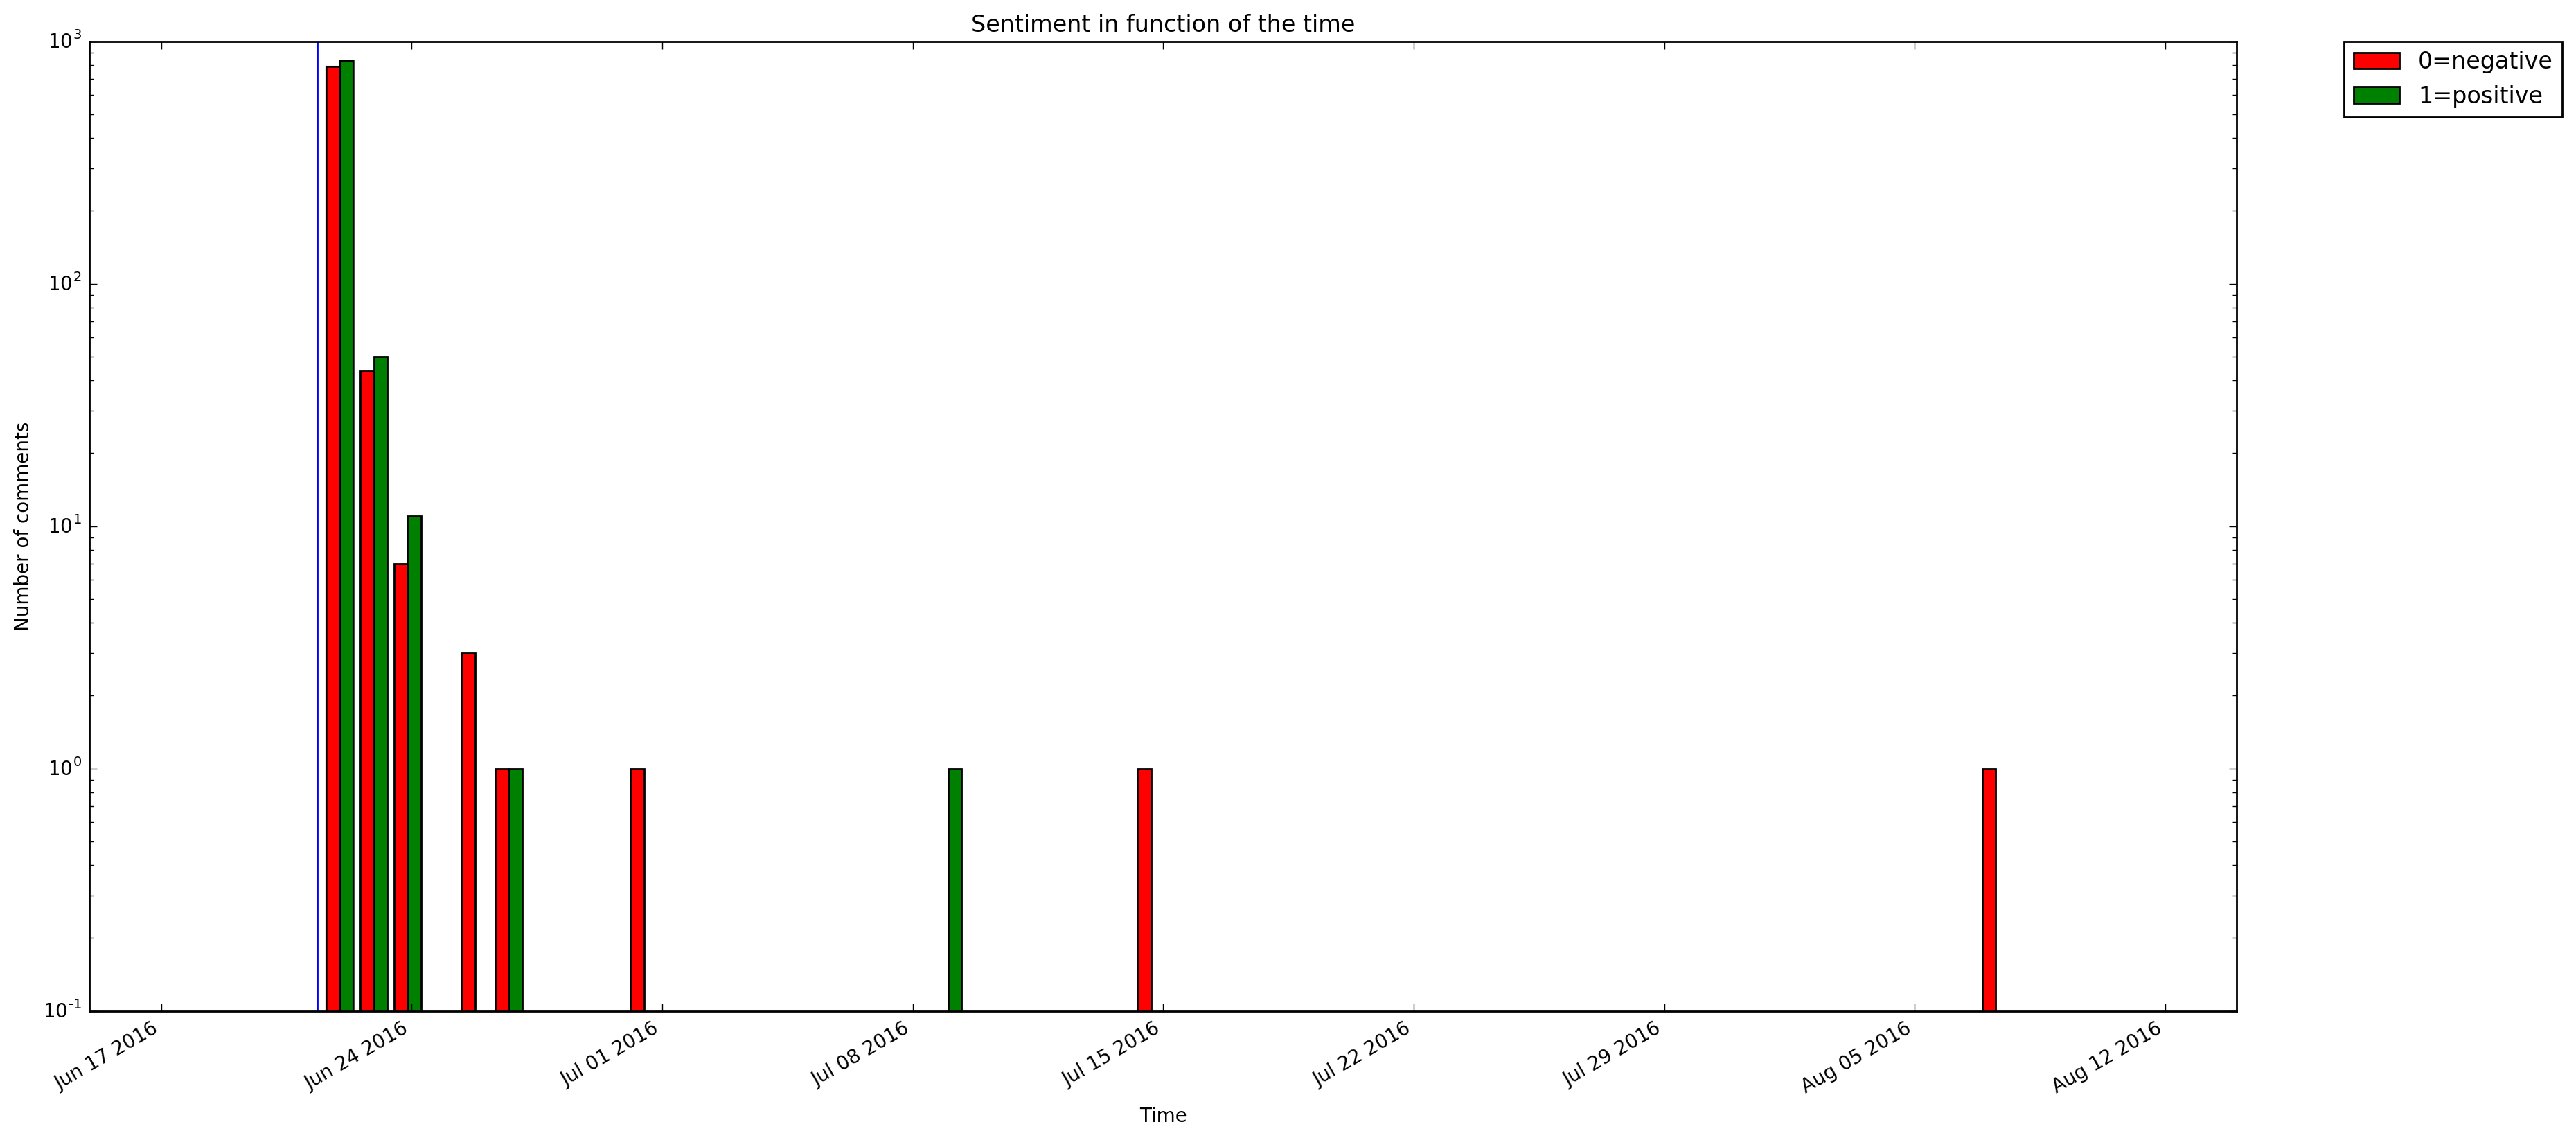

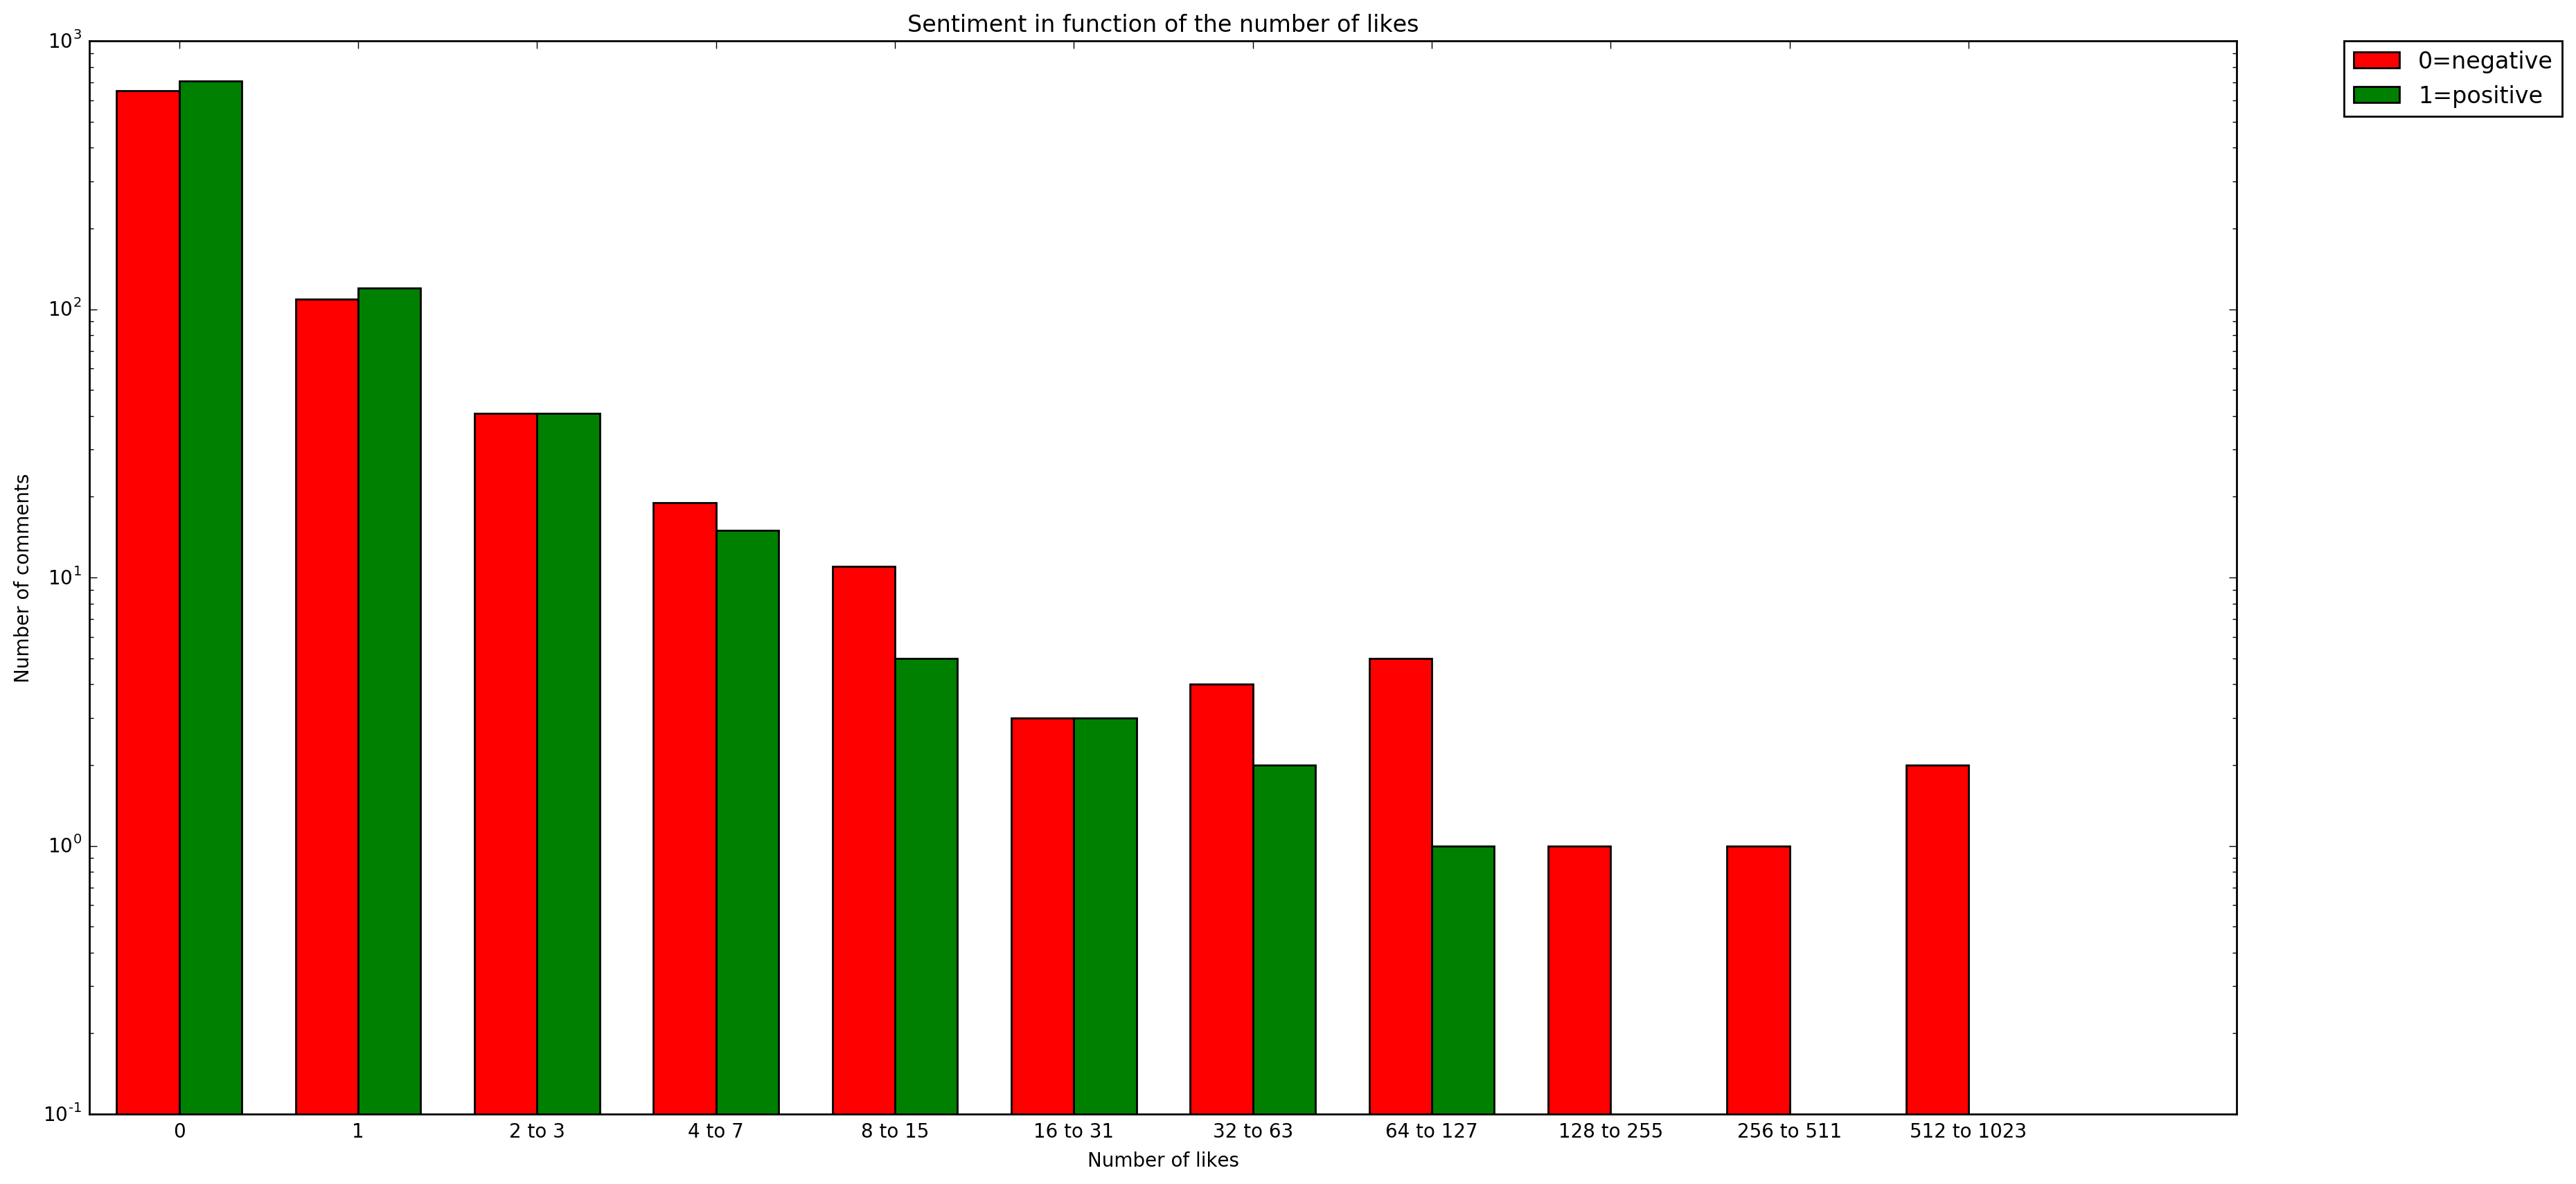

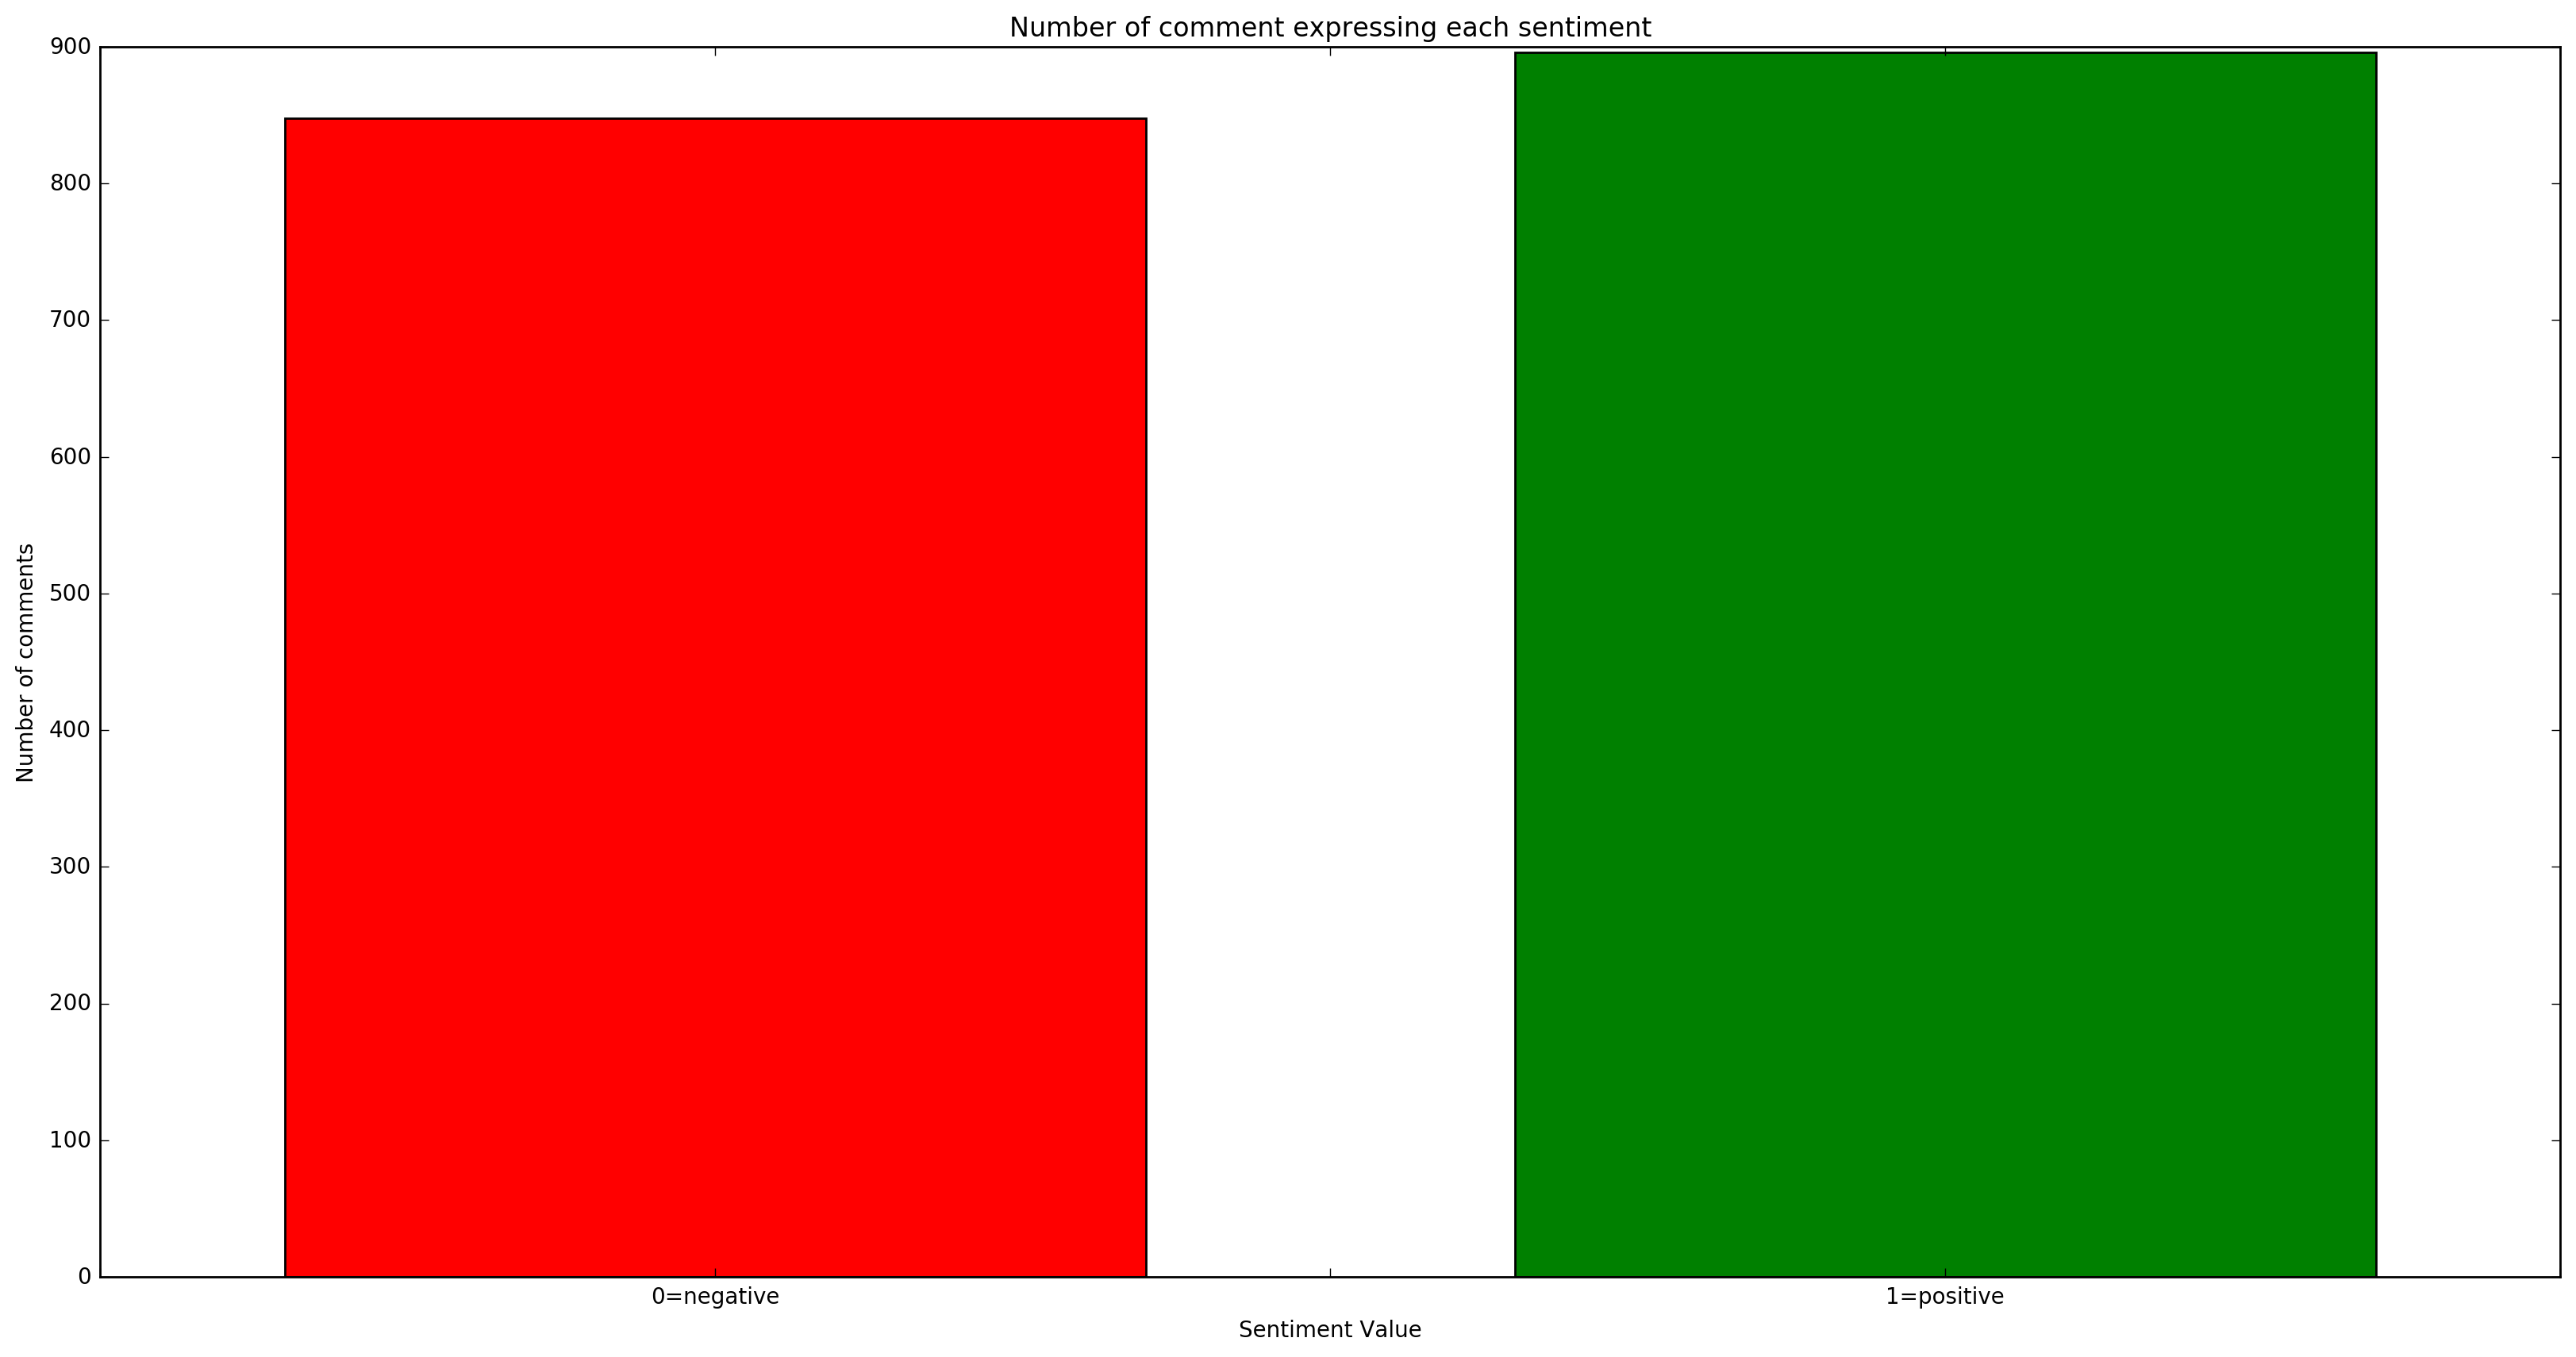

Post sentiment:  1


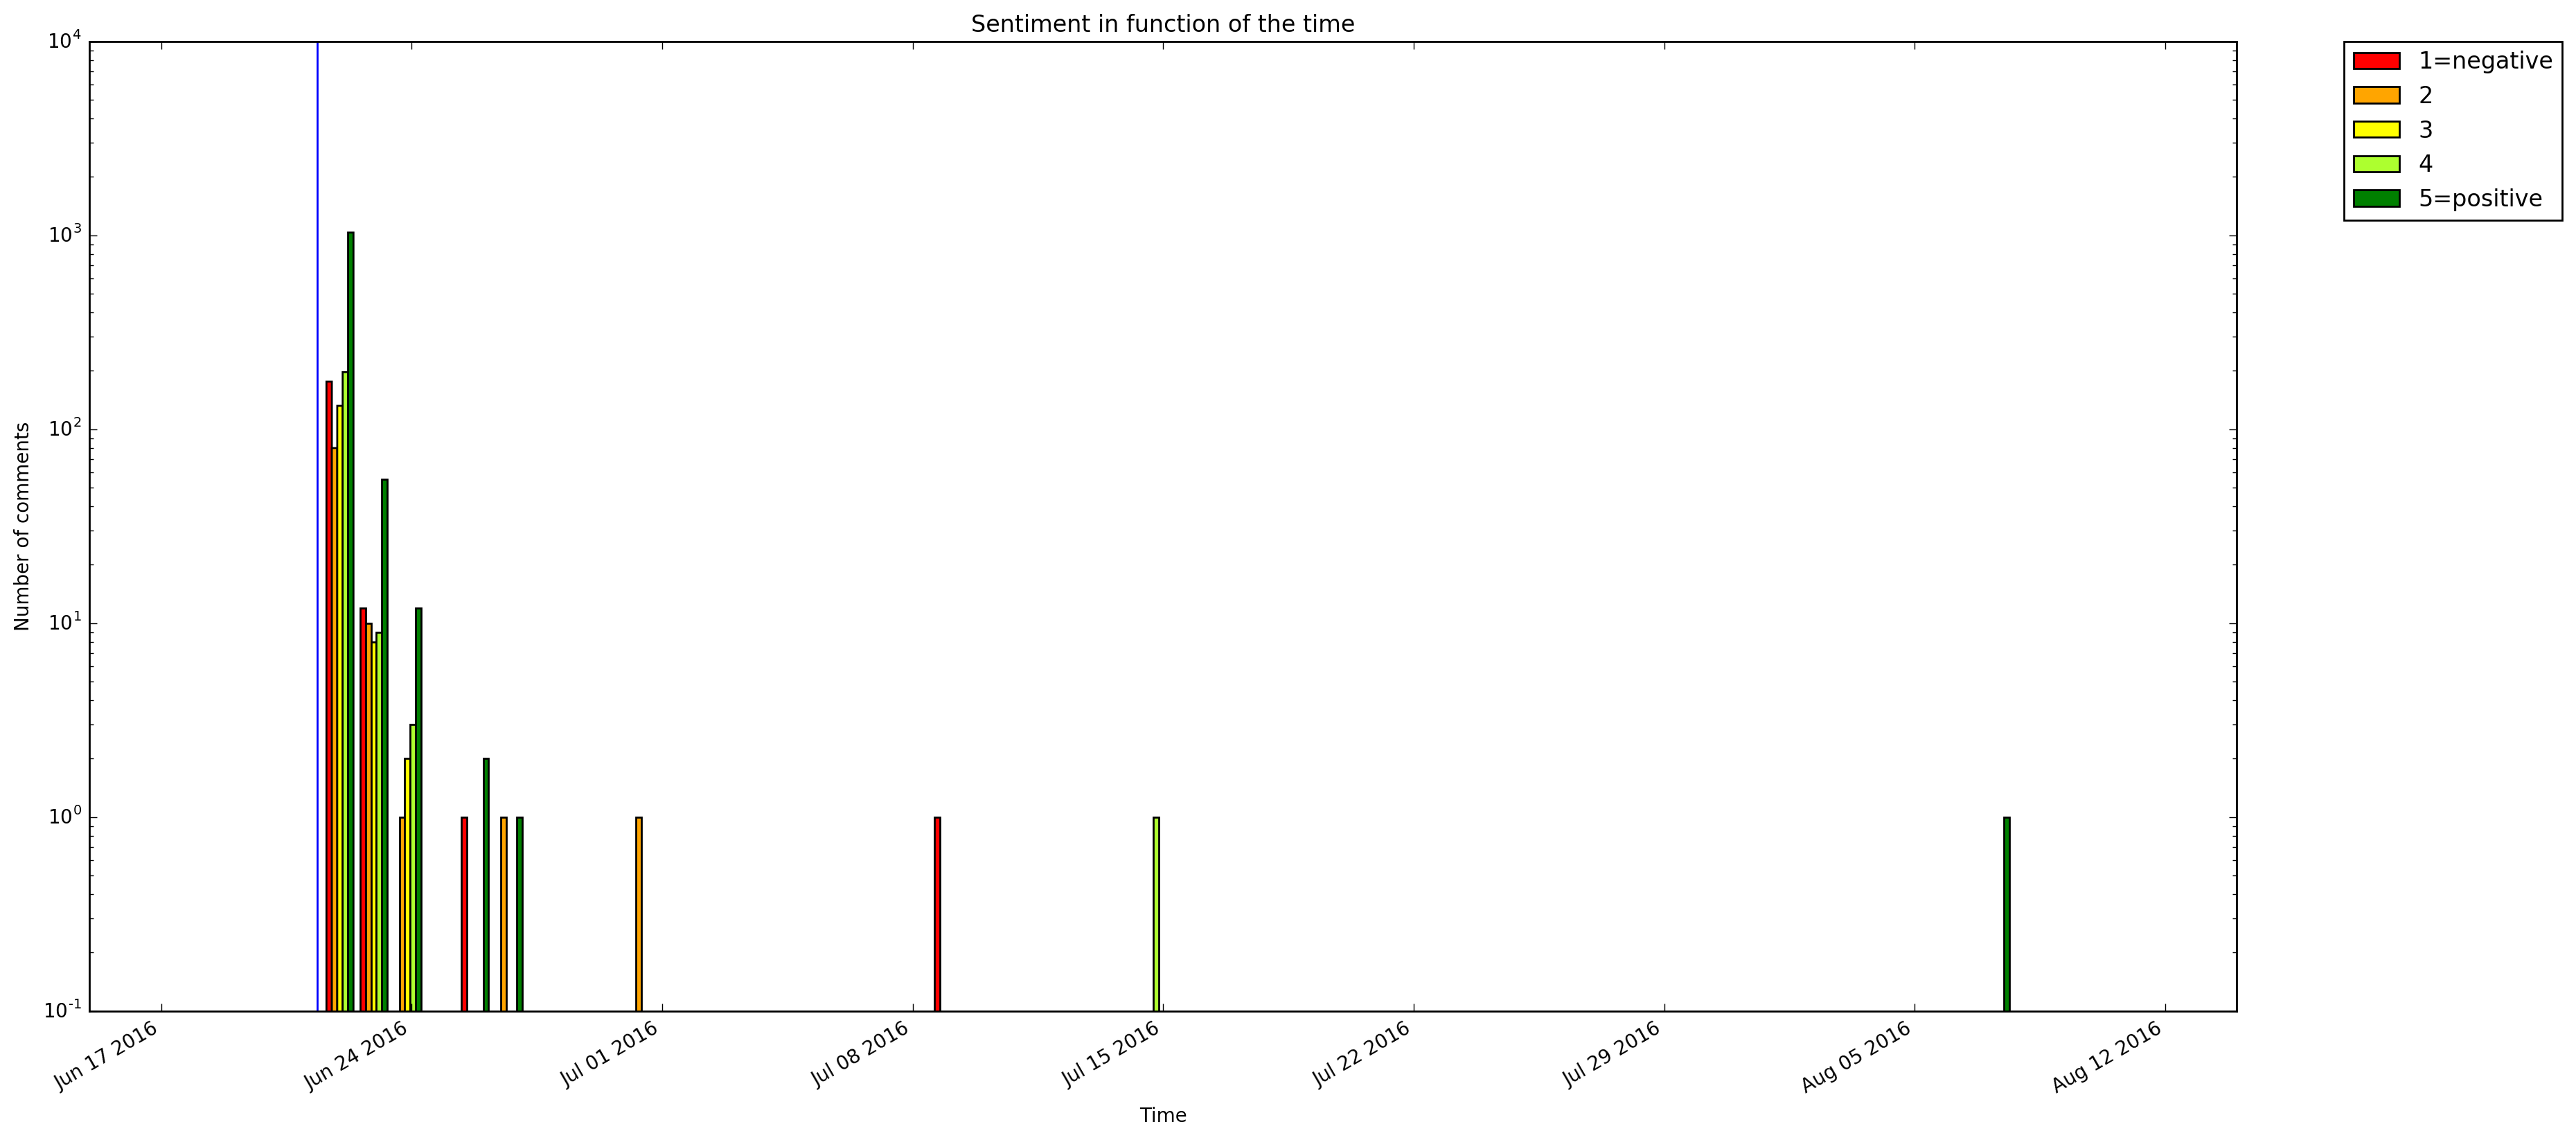

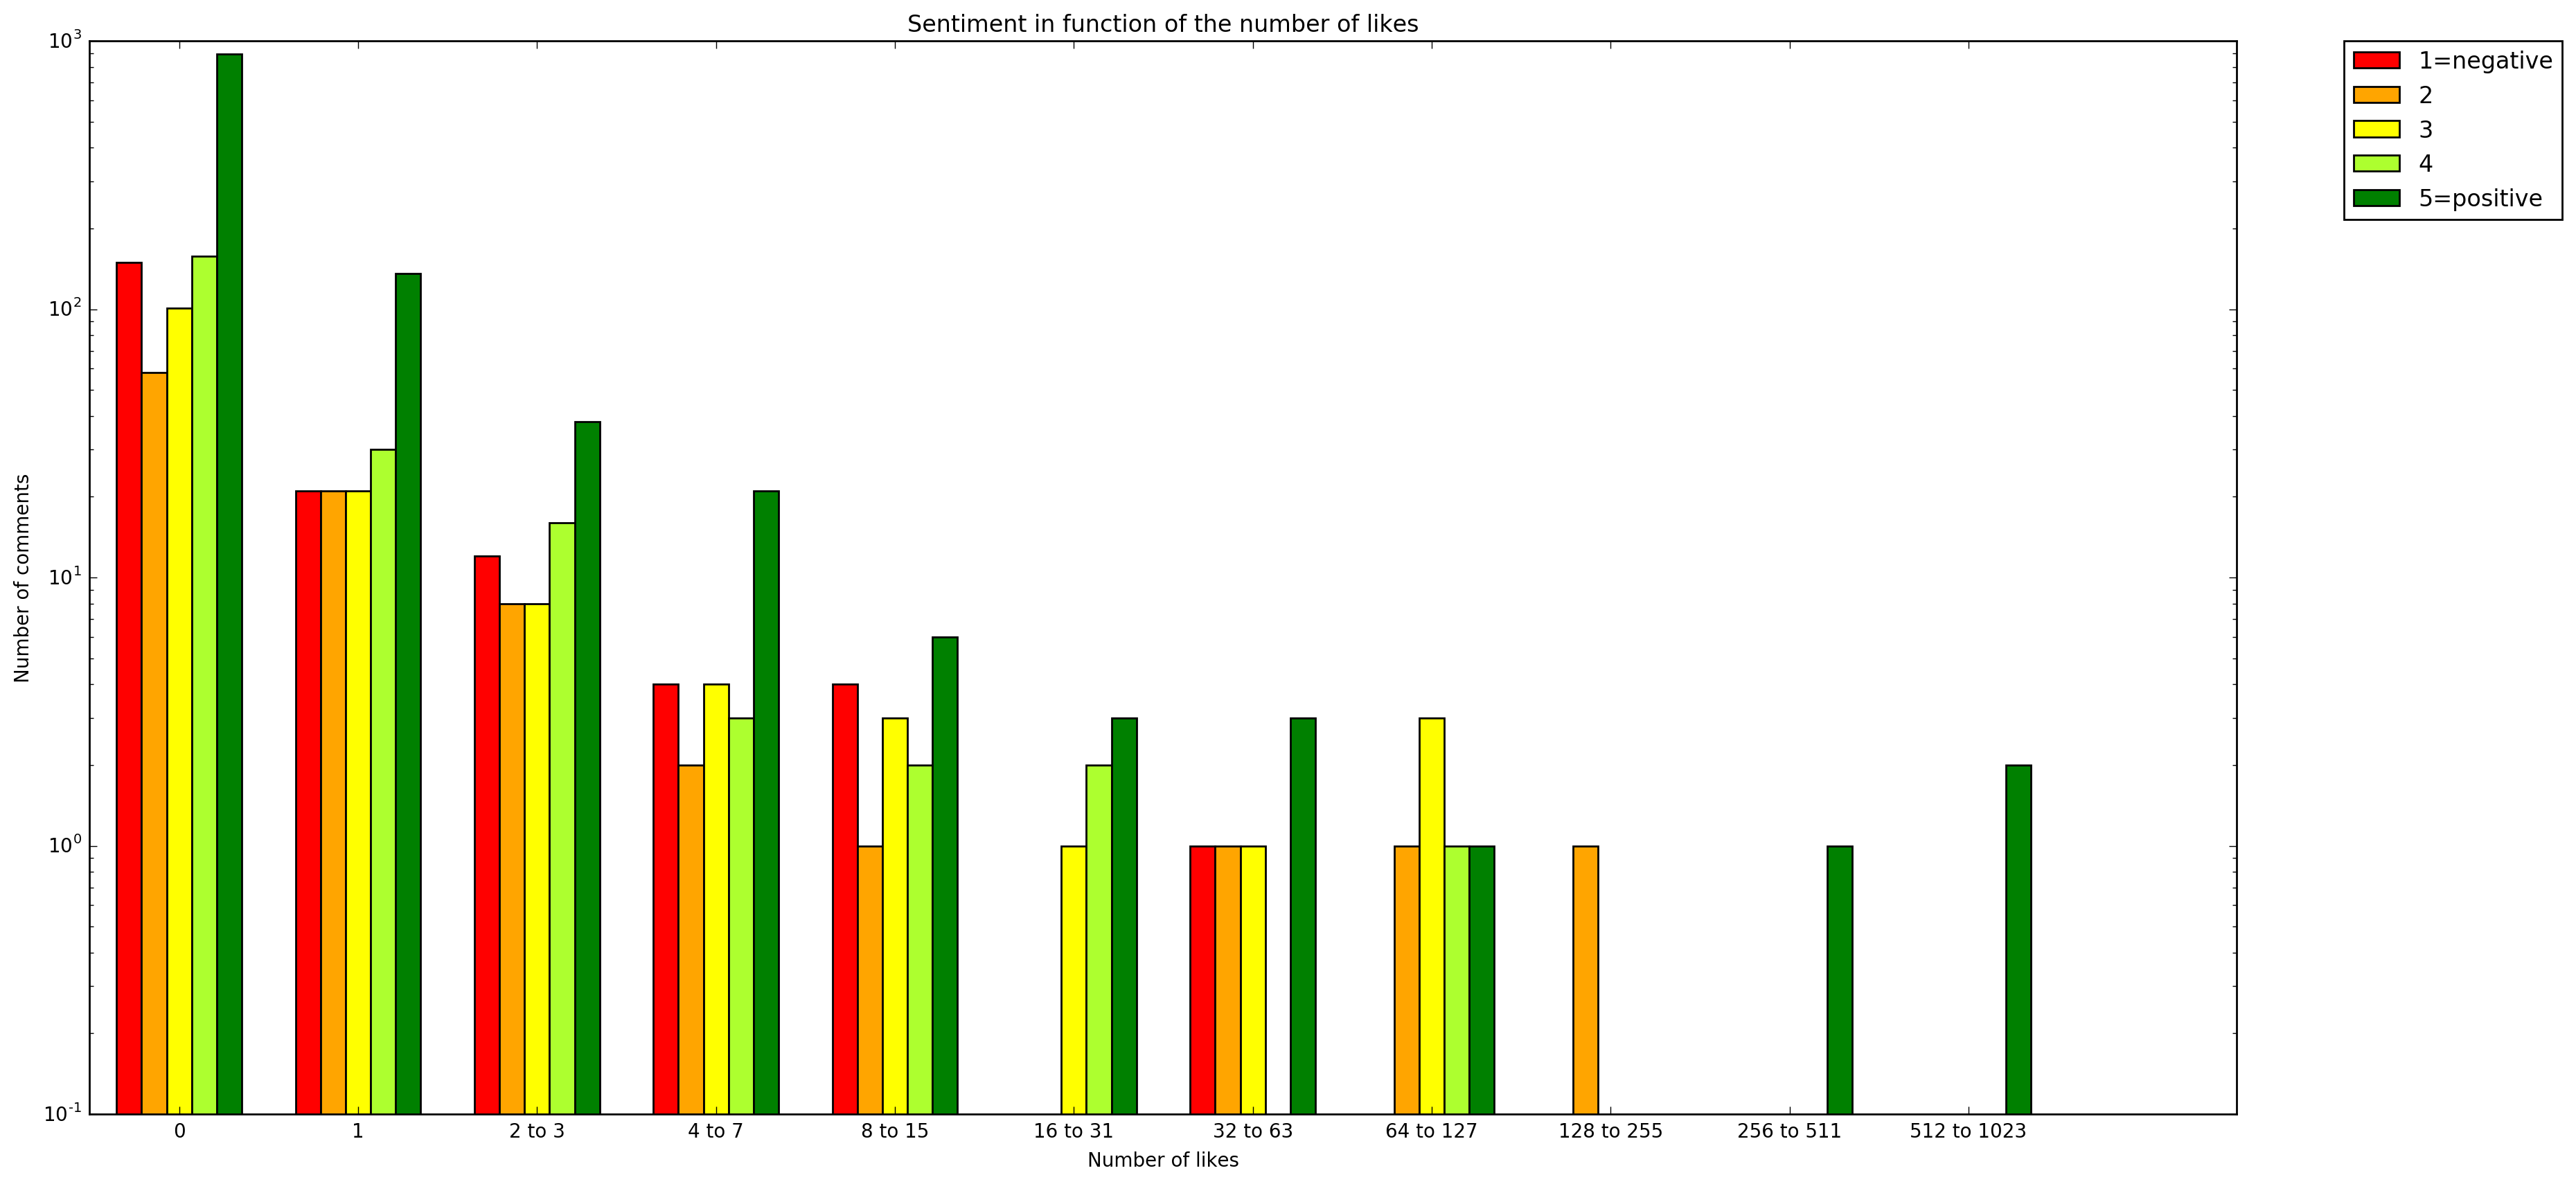

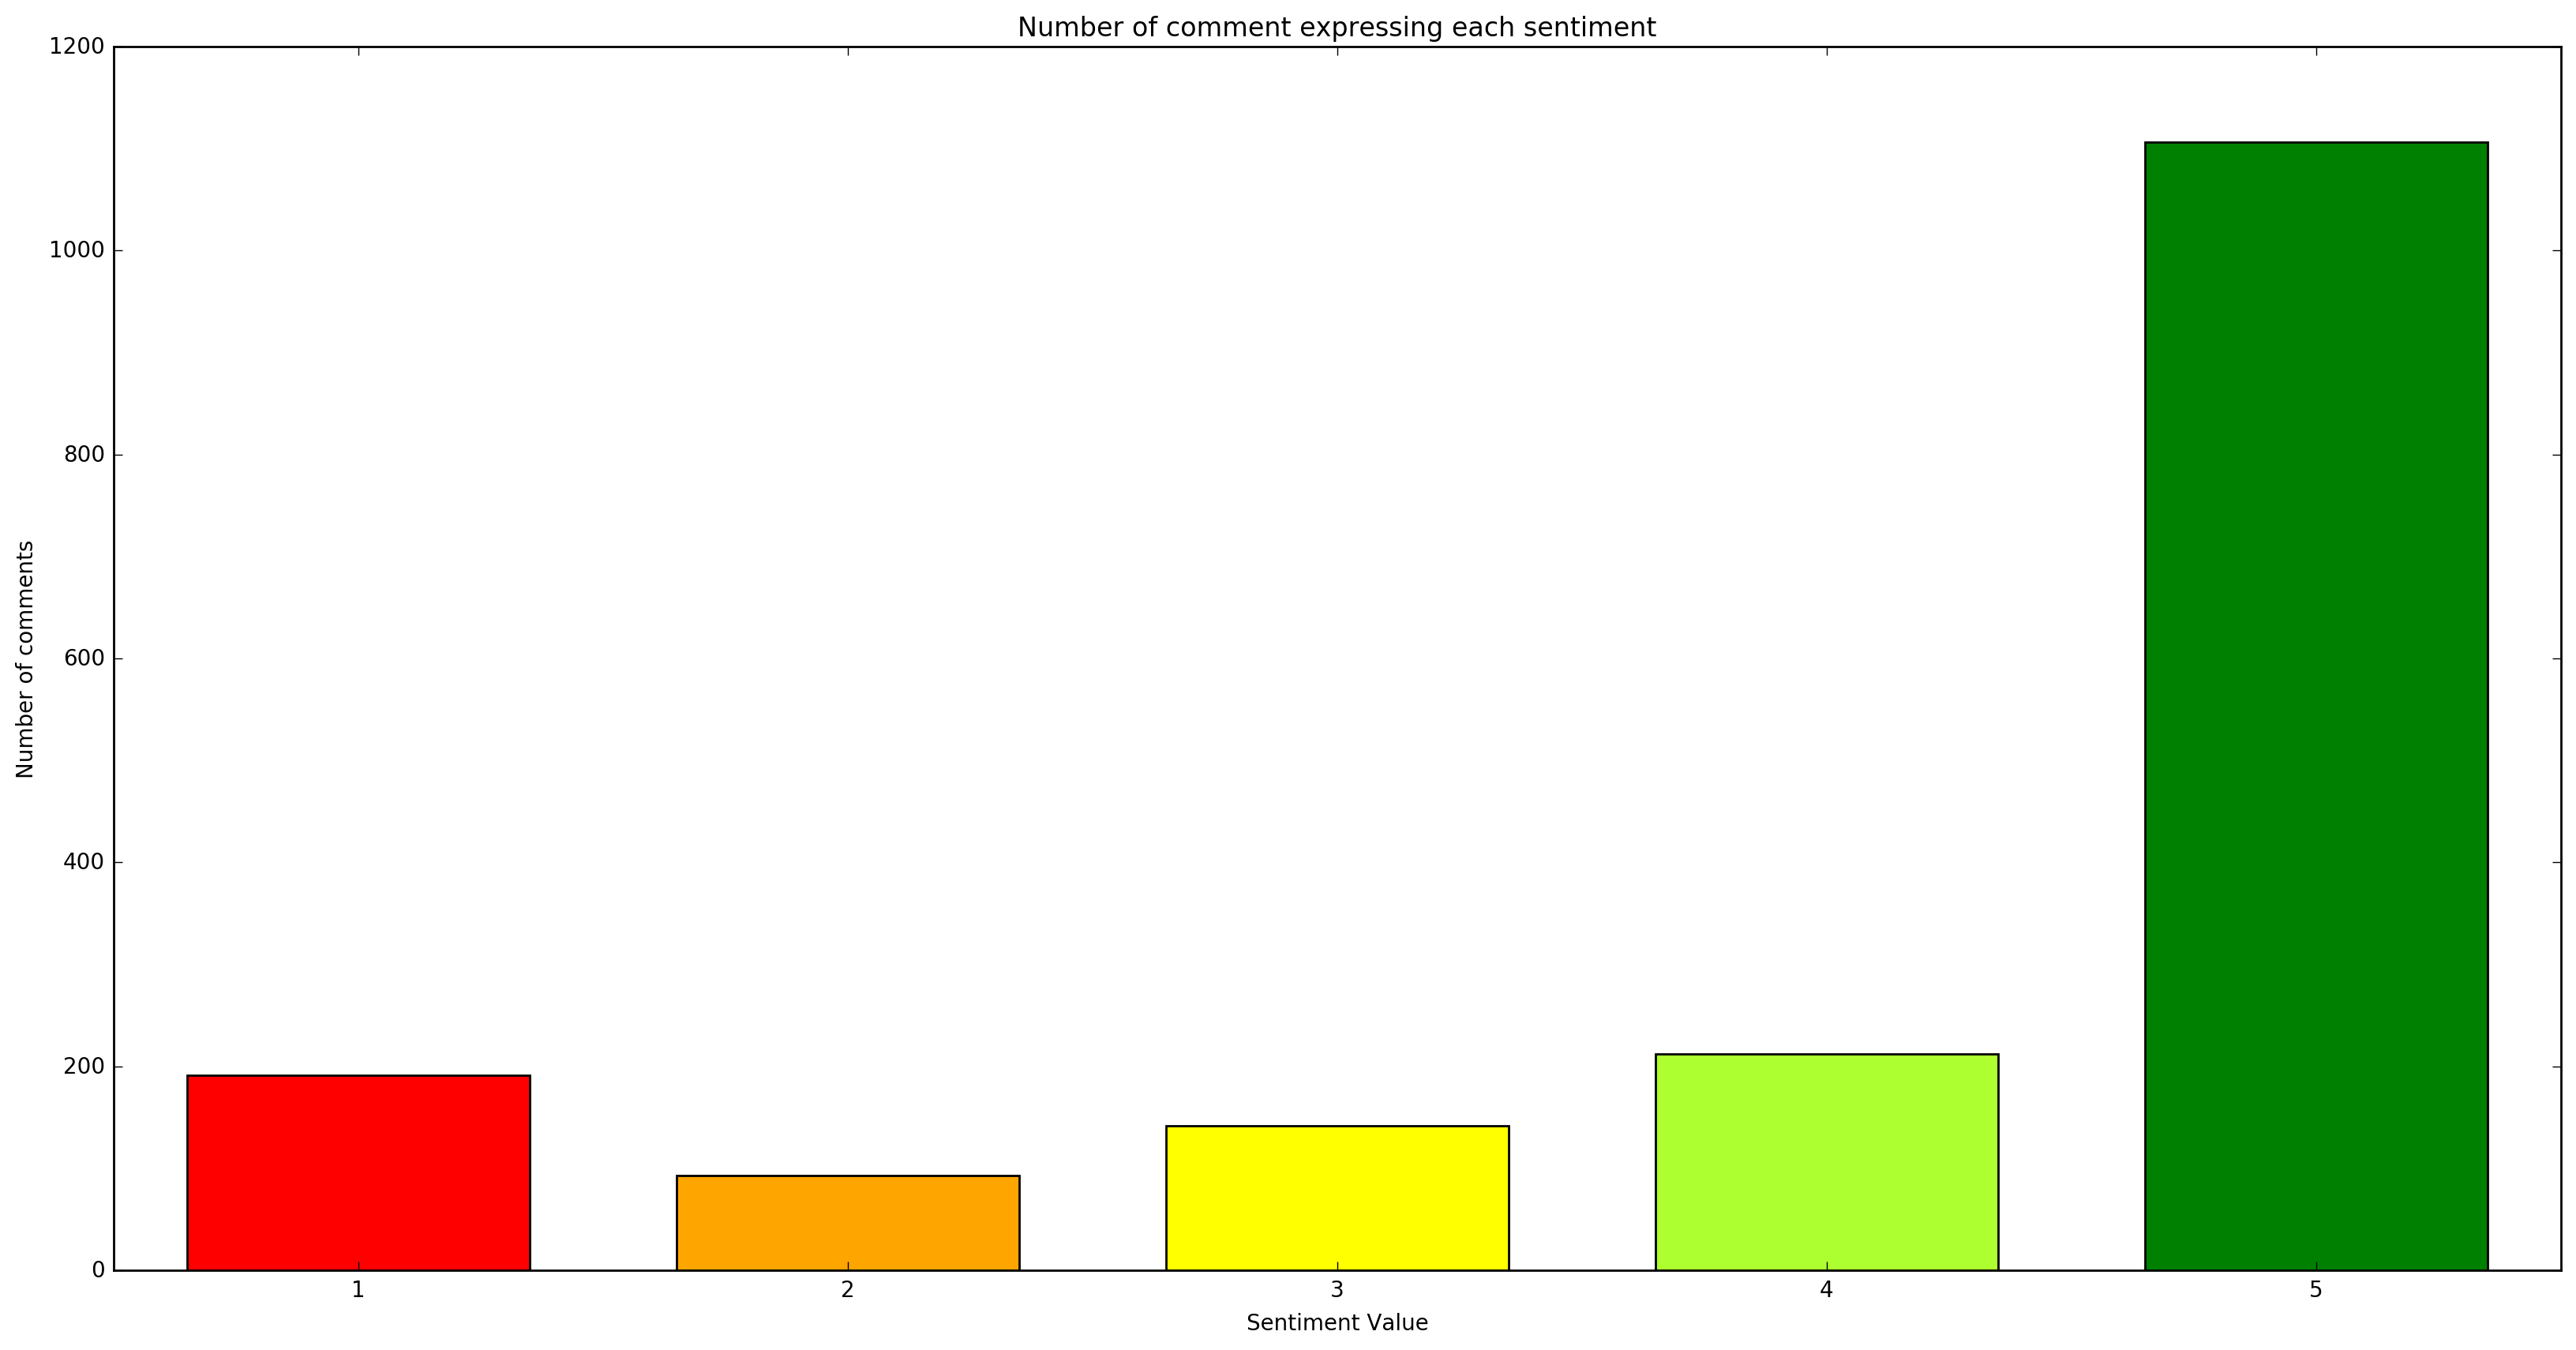

Post sentiment:  4.0


In [24]:
page = 'DavidCameronOfficial'
postId= '1216426805048302'
fb= postReactions(postId,1,'DC1')
filename='facebookDC1.sqlite'
getAllGraphsForPost(filename,50) 

David Cameron 'thank you' note to the voters

In [ ]:
postId= '1218229621534687'
fb= postReactions(postId,0,'DC2')
filename='facebookDC2.sqlite'
getAllGraphsForPost(filename,50) 

#### US presidential election

Hillary Clinton asking for votes (before election)

In [ ]:
#page = 'hillaryclinton'
#postId= '1322830897773436'
#fb= postReactions(postId,1,'HC3')
filename='facebookHC3.sqlite'
getAllGraphsForPost(filename,50) 

Hillary Clinton defeat speech

In [ ]:
#postId= '1324421317614394'
#fb= postReactions(postId,0,'HC2')
filename='facebookHC2.sqlite'
getAllGraphsForPost(filename,50)

Donald Trump about winning more votes

In [ ]:
#page = 'DonaldTrump'
#postId= '10158135498775725'
#fb= postReactions(postId,0,'DT5')
filename='facebookDT5.sqlite'
getAllGraphsForPost(filename,50)

Donald Trump speaks about the defeat of the democrats

In [ ]:
#page = 'DonaldTrump'
#postId= '10158423167515725'
#fb= postReactions(postId,0,'DT3')
filename='facebookDT3.sqlite'
getAllGraphsForPost(filename,50)

#### Donald Trump
Donald Trump reaction to Meryl Streep speach

In [ ]:
#page = 'DonaldTrump'
#postId= '10158439095420725'
#fb= postReactions(postId,0,'DT1')
filename='facebookDT1.sqlite'
getAllGraphsForPost(filename,50)

Donald Trump speaks about a good relationship with Russia

In [ ]:
#postId= '10158430269170725'
#fb= postReactions(postId,0,'DT2')
filename='facebookDT2.sqlite'
getAllGraphsForPost(filename,50)

Donald Trump speaks about Obamacare

In [ ]:
#postId= '10158417912085725'
#fb= postReactions(postId,0,'DT4')
filename='facebookDT4.sqlite'
getAllGraphsForPost(filename,50)

### Theme : Environmental
#### Dakota Pipeline

AJ+ post on Native Americans fighting against the Dakota Access pipeline

In [ ]:
#page='ajplusenglish'
#postId='843345759140266'
#fb= postReactions(postId,1,'ENV1')
filename='facebookENV1.sqlite'
getAllGraphsForPost(filename,50)




AJ+ post on celebrations after the U.S. Army Corp of Engineers refused to grant 
an easement allowing the Dakota Access Pipeline to go under Lake Oahe

In [ ]:
#postId='852012618273580'
#fb= postReactions(postId,0,'ENV2')
filename='facebookENV2.sqlite'
getAllGraphsForPost(filename,50)

#### Donald Trump and environmental issues
AJ+ post on the hackers that are preserving environmental data before Trump takes office

In [ ]:
#postId='864548553686653'
#fb= postReactions(postId,1,'ENV3')
filename='facebookENV3.sqlite'
getAllGraphsForPost(filename,50)

AJ+ post on Donald Trump being picked for the Environmental Protection Agency not believing in man-made climate change. 

In [ ]:
#postId='855199717954870'
#fb= postReactions(postId,1,'ENV4')
filename='facebookENV4.sqlite'
getAllGraphsForPost(filename,50)

### Theme : Homosexuality

CNN post on Pope saying Christians should apologize to gay people

In [ ]:
#page='cnninternational'
#postId='10154249259664641'
#fb= postReactions(postId,1,'HM1')
filename='facebookHM1.sqlite'
getAllGraphsForPost(filename,50)

CNN post on  the fact that more than half of British Muslims think homosexuality should be illegal

In [ ]:
postId='10154056181289641'
fb= postReactions(postId,1,'HM2')
display(fb[:])
#filename='facebookHM2.sqlite'
#def getAllGraphsForPost(filename,50)

## Analysis  on pages
### CNN

In [ ]:
#page='cnninternational'
#lastPostsReactions(page,'CNN',20)
filename='facebookCNN.sqlite'
fb=getTable('facebookCNN.sqlite')
getAllGraphsForPage(filename,50)

### Donald Trump

In [ ]:
page='DonaldTrump'
lastPostsReactions(page,'DT',20)
filename='facebookDT.sqlite' 
#getAllGraphsForPage(filename,50)

### Hillary Clinton

In [ ]:
page = 'hillaryclinton'
lastPostsReactions(page,'HC',20)
filename='facebookHC.sqlite'
def getAllGraphsForPage(filename,50)

### 9GAG

In [ ]:
page='9gag'
lastPostsReactions(page,'9GAG',1)
filename='faceboo9GAG.sqlite'
#getAllGraphsForPage(filename,50)

### Love What Really Matters

In [ ]:
page='lovewhatreallymatters'
lastPostsReactions(page,'LOVE',20)
filename='facebooLOVE.sqlite'
getAllGraphsForPage(filename,50)